# Import Required Libraries and Ensure Dependencies

This section imports all necessary libraries and ensures that required packages are installed using a helper function.

In [12]:
import importlib
import sys
import subprocess

def ensure_package(pkg, pip_name=None):
    try:
        importlib.import_module(pkg)
    except ImportError:
        pip_pkg = pip_name if pip_name else pkg
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_pkg])

# Check and install required packages
ensure_package("matplotlib")
ensure_package("numpy")
ensure_package("statsmodels")
ensure_package("seaborn")
ensure_package("ruptures")
ensure_package("mplcursors")
ensure_package("pandas") 
ensure_package("scikit-learn", "scikit-learn")

# Standard library
import re

# Interactive plotting
import mplcursors

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Statistical modeling and time series analysis
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR

# Machine learning
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression

# Change point detection
import ruptures as rpt

# Jupyter display utilities
from IPython.display import display, Markdown

# Extract Demographic Group Names from README

Parse the README.txt file to extract demographic group names for use as column headers in the dataset.

In [2]:
# Read the README.txt file and extract headers for the CSV file
with open('data/README.txt', 'r') as f:
    lines = f.readlines()

clean_series_names = []
for i, line in enumerate(lines):
    if line.strip().lower().startswith('title'):
        if i + 1 < len(lines):
            header_line = lines[i + 1].strip()
            if 'Unemployment Rate - ' in header_line:
                # Split at 'Unemployment Rate - ' and then at the first double space
                part = header_line.split('Unemployment Rate - ', 1)[1]
                name = part.split('  ', 1)[0].strip()
                clean_series_names.append(name)
            elif header_line.startswith('Unemployment Rate'):
                # Generic "Unemployment Rate" (no dash)
                clean_series_names.append('Unemployment Rate')
print(clean_series_names)

['Asian', 'White', 'Black or African American', 'Hispanic or Latino', 'Foreign Born', 'Native Born', 'Unemployment Rate']


# Load and Prepare Unemployment Data

Read the CSV file containing unemployment data, assign new headers, and convert the date column to datetime.

In [3]:
# Read the CSV file (assuming the file path is 'data.csv')
df = pd.read_csv('data/monthly.csv')

# Change the headers: first column to 'date', rest to clean_series_names
new_headers = ['Date'] + clean_series_names
df.columns = new_headers
df['Date'] = pd.to_datetime(df['Date'])
df.head()

Date  Asian  White  Black or African American  Hispanic or Latino  \
0 1948-01-01    NaN    NaN                        NaN                 NaN   
1 1948-02-01    NaN    NaN                        NaN                 NaN   
2 1948-03-01    NaN    NaN                        NaN                 NaN   
3 1948-04-01    NaN    NaN                        NaN                 NaN   
4 1948-05-01    NaN    NaN                        NaN                 NaN   

   Foreign Born  Native Born  Unemployment Rate  
0           NaN          NaN                4.0  
1           NaN          NaN                4.7  
2           NaN          NaN                4.5  
3           NaN          NaN                4.0  
4           NaN          NaN                3.4

# Subset and Clean DataFrames

Create DataFrames for overall unemployment and for all groups, removing rows with missing values.

In [4]:
# Create a DataFrame with only the 'Unemployment Rate' column (plus Date)
df_unemployment = df[['Date', 'Unemployment Rate']].dropna()

# Truncate the original df to remove any rows with null values in any column
df_truncated = df.dropna()

# Print the head of each DataFrame
print("Unemployment Rate Only:")
print(df_unemployment.head())

print("\nTruncated Original DataFrame (no nulls):")
print(df_truncated.head())

Unemployment Rate Only:
        Date  Unemployment Rate
0 1948-01-01                4.0
1 1948-02-01                4.7
2 1948-03-01                4.5
3 1948-04-01                4.0
4 1948-05-01                3.4

Truncated Original DataFrame (no nulls):
          Date  Asian  White  Black or African American  Hispanic or Latino  \
708 2007-01-01    3.1    4.6                        8.2                 6.4   
709 2007-02-01    2.6    4.4                        8.2                 5.8   
710 2007-03-01    3.0    4.0                        8.3                 5.4   
711 2007-04-01    3.5    3.8                        7.8                 5.2   
712 2007-05-01    3.2    3.7                        8.1                 5.3   

     Foreign Born  Native Born  Unemployment Rate  
708           4.8          5.1                5.0  
709           4.8          4.9                4.9  
710           4.1          4.6                4.5  
711           4.1          4.3                4.3  
712    

# Plot Unemployment Rate by Demographic Group

Plot time series of unemployment rates for each demographic group and their 12-month moving averages.

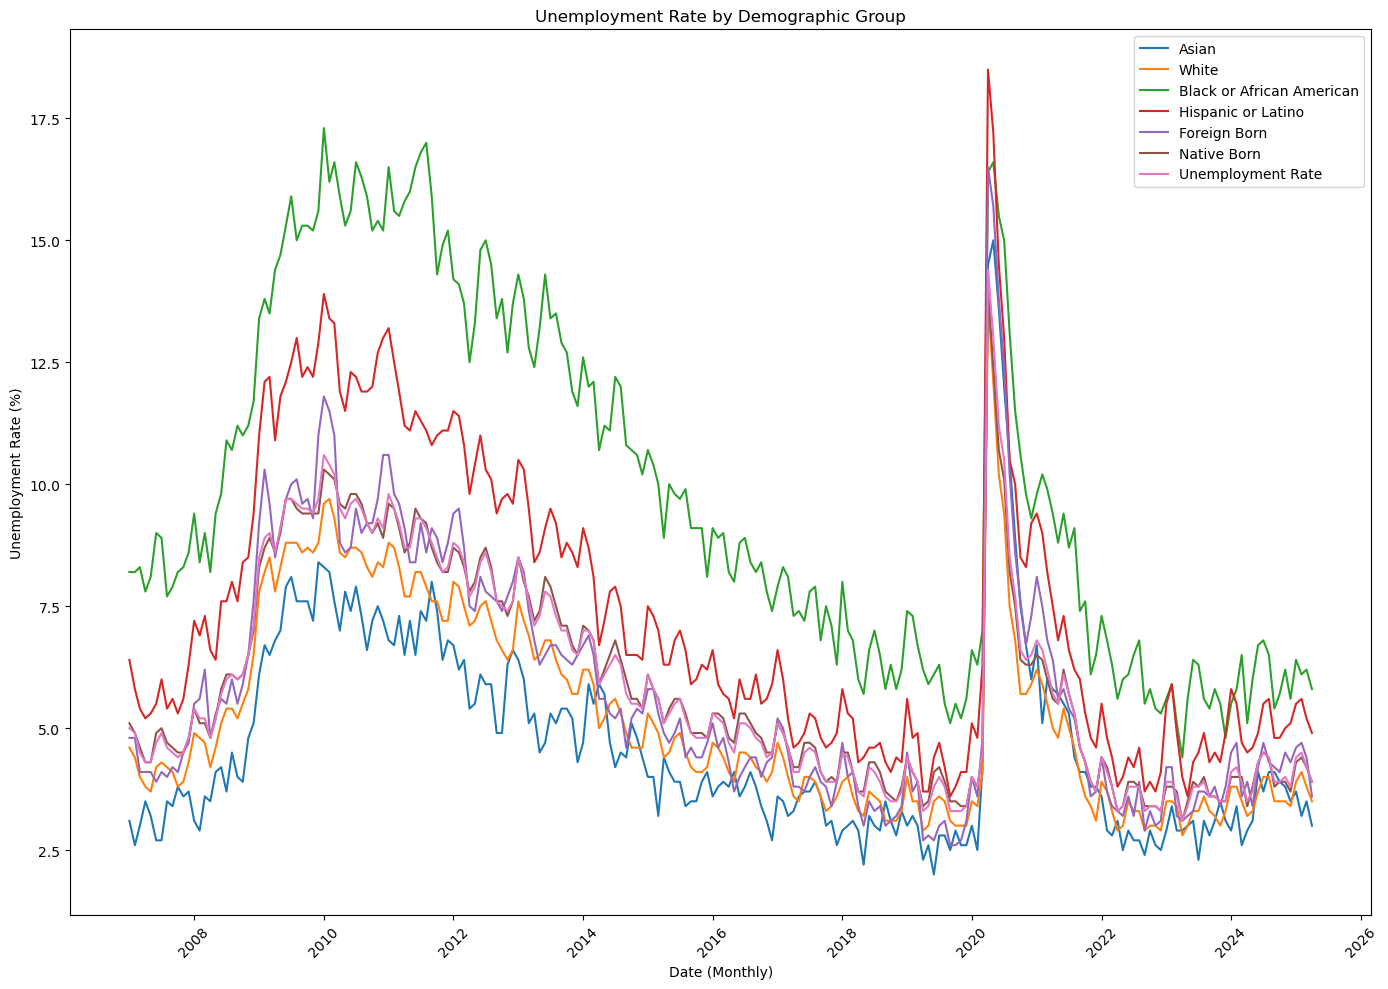



### Chart 1: Unemployment Rate by Demographic Group

This chart shows the monthly unemployment rate for each demographic group over time. Each line represents a different group, allowing you to visually compare trends, spikes, and recoveries across populations.


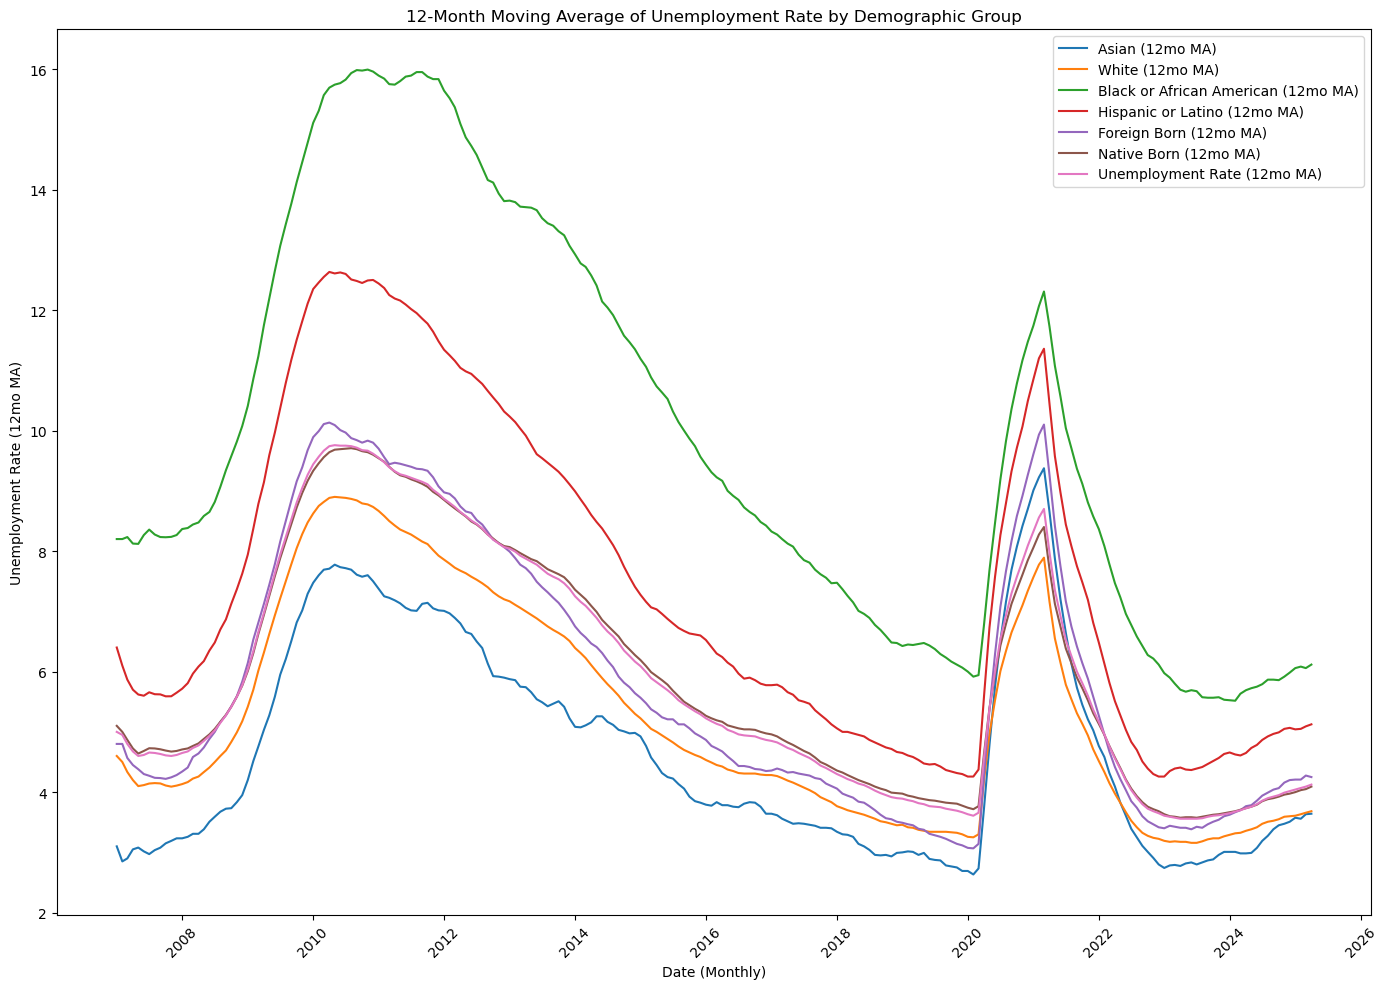



### Chart 2: 12-Month Moving Average of Unemployment Rate by Demographic Group

This chart displays the 12-month moving average for each group's unemployment rate. The moving average smooths out short-term fluctuations, highlighting longer-term trends and cycles in unemployment for each demographic.

**How is the moving average calculated?**

For each month, the average unemployment rate is computed over the current and previous 11 months. This helps reveal underlying trends by reducing the impact of random month-to-month changes.


In [5]:
# Plot time series for each demographic group in df_truncated
plt.figure(figsize=(14, 10))
for col in clean_series_names:
    plt.plot(df_truncated['Date'], df_truncated[col], label=col)
plt.xlabel('Date (Monthly)')
plt.ylabel('Unemployment Rate (%)')
plt.title('Unemployment Rate by Demographic Group')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

display(Markdown("""
                 
### Chart 1: Unemployment Rate by Demographic Group

This chart shows the monthly unemployment rate for each demographic group over time. Each line represents a different group, allowing you to visually compare trends, spikes, and recoveries across populations.
"""))
                 

# Rolling averages (12-month moving average)
plt.figure(figsize=(14, 10))
for col in clean_series_names:
    plt.plot(df_truncated['Date'], df_truncated[col].rolling(window=12, min_periods=1).mean(), label=f"{col} (12mo MA)")
plt.xlabel('Date (Monthly)')
plt.ylabel('Unemployment Rate (12mo MA)')
plt.title('12-Month Moving Average of Unemployment Rate by Demographic Group')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

display(Markdown("""

### Chart 2: 12-Month Moving Average of Unemployment Rate by Demographic Group

This chart displays the 12-month moving average for each group's unemployment rate. The moving average smooths out short-term fluctuations, highlighting longer-term trends and cycles in unemployment for each demographic.

**How is the moving average calculated?**

For each month, the average unemployment rate is computed over the current and previous 11 months. This helps reveal underlying trends by reducing the impact of random month-to-month changes.
"""))



# STL Decomposition for Selected Groups

Perform STL decomposition on selected demographic groups and plot the observed, trend, seasonal, and residual components.

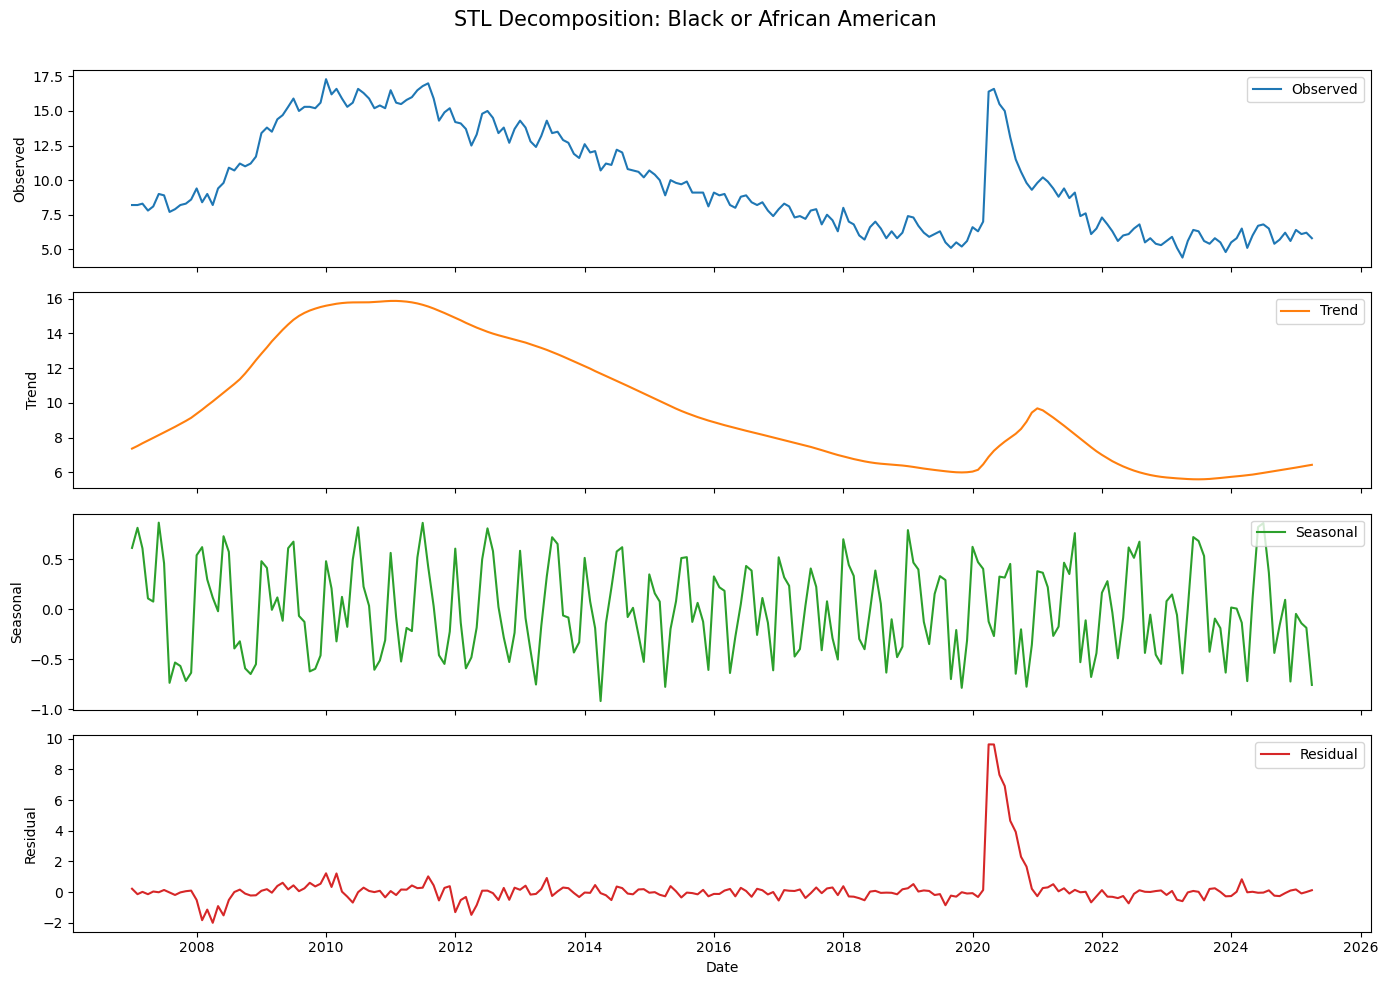

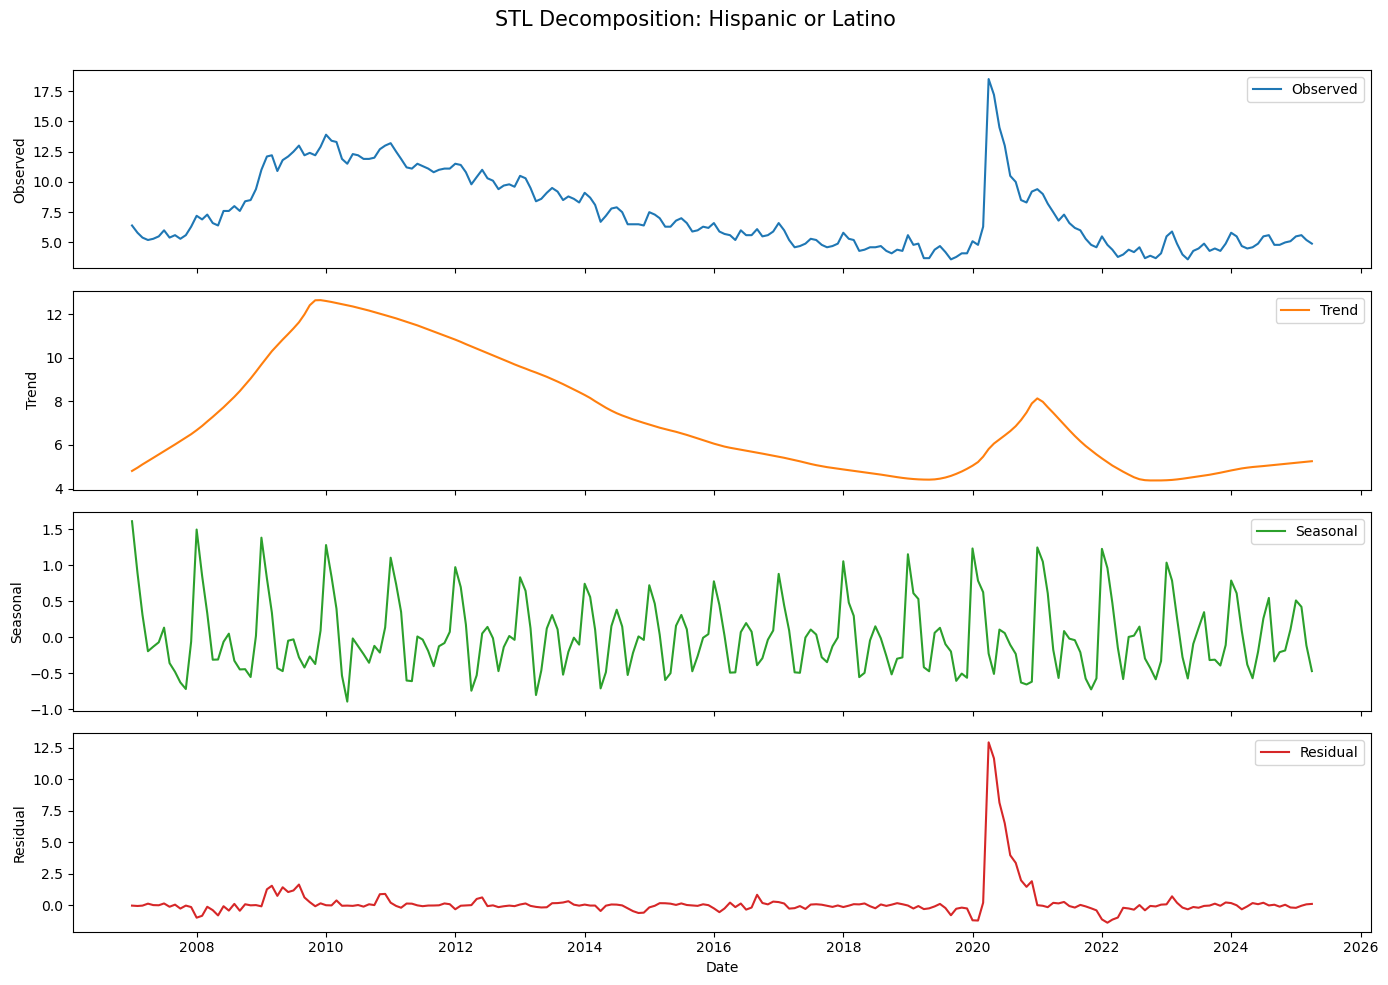


### STL Decomposition: Black or African American and Hispanic or Latino Groups

For each selected demographic group, the STL (Seasonal-Trend decomposition using Loess) chart is shown in a standard 4-panel layout:

1. **Observed:**  
    The top panel displays the original unemployment rate time series for the group. This shows the raw monthly data, including all fluctuations.

2. **Trend:**  
    The second panel shows the long-term trend component extracted from the data. This highlights the underlying direction of unemployment over time, smoothing out short-term variations.

3. **Seasonal:**  
    The third panel presents the seasonal component, capturing regular, repeating patterns within each year (such as seasonal employment cycles).

4. **Residual:**  
    The bottom panel displays the residual (remainder) component, representing irregular fluctuations not explained by the trend or seasonality. These may correspond to unexpected shocks or noise.

**Interpretation:**  
- The decomposition helps isolate persistent trends (e.g., improvement or worsening in unemployment), recurring seasonal effects, and unusual events.
- Comparing the two groups side by side reveals differences in long-term trends and the magnitude or timing of seasonal effects.
- Large spikes or dips in the residuals may indicate periods of economic stress or recovery unique to each group.

STL decomposition is a powerful tool for understanding the structure of time series data and for identifying both systematic and irregular changes in unemployment rates across demographic groups.


In [6]:
# STL decomposition for Black or African American and Hispanic or Latino groups (standard 4-panel style)
selected_groups = ['Black or African American', 'Hispanic or Latino']

for group in selected_groups:
    series = pd.Series(df_truncated[group].values, index=df_truncated['Date'])
    stl = sm.tsa.STL(series, period=12, robust=True)
    result = stl.fit()
    fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
    axes[0].plot(series.index, series.values, label='Observed', color='tab:blue')
    axes[0].set_ylabel('Observed')
    axes[0].legend(loc='upper right')
    axes[1].plot(series.index, result.trend, label='Trend', color='tab:orange')
    axes[1].set_ylabel('Trend')
    axes[1].legend(loc='upper right')
    axes[2].plot(series.index, result.seasonal, label='Seasonal', color='tab:green')
    axes[2].set_ylabel('Seasonal')
    axes[2].legend(loc='upper right')
    axes[3].plot(series.index, result.resid, label='Residual', color='tab:red')
    axes[3].set_ylabel('Residual')
    axes[3].legend(loc='upper right')
    axes[3].set_xlabel('Date')
    fig.suptitle(f'STL Decomposition: {group}', fontsize=15)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

display(Markdown("""
### STL Decomposition: Black or African American and Hispanic or Latino Groups

For each selected demographic group, the STL (Seasonal-Trend decomposition using Loess) chart is shown in a standard 4-panel layout:

1. **Observed:**  
    The top panel displays the original unemployment rate time series for the group. This shows the raw monthly data, including all fluctuations.

2. **Trend:**  
    The second panel shows the long-term trend component extracted from the data. This highlights the underlying direction of unemployment over time, smoothing out short-term variations.

3. **Seasonal:**  
    The third panel presents the seasonal component, capturing regular, repeating patterns within each year (such as seasonal employment cycles).

4. **Residual:**  
    The bottom panel displays the residual (remainder) component, representing irregular fluctuations not explained by the trend or seasonality. These may correspond to unexpected shocks or noise.

**Interpretation:**  
- The decomposition helps isolate persistent trends (e.g., improvement or worsening in unemployment), recurring seasonal effects, and unusual events.
- Comparing the two groups side by side reveals differences in long-term trends and the magnitude or timing of seasonal effects.
- Large spikes or dips in the residuals may indicate periods of economic stress or recovery unique to each group.

STL decomposition is a powerful tool for understanding the structure of time series data and for identifying both systematic and irregular changes in unemployment rates across demographic groups.
"""))





# ACF and PACF Analysis

Generate and plot ACF and PACF for a selected group's unemployment rate to analyze autocorrelation structure.

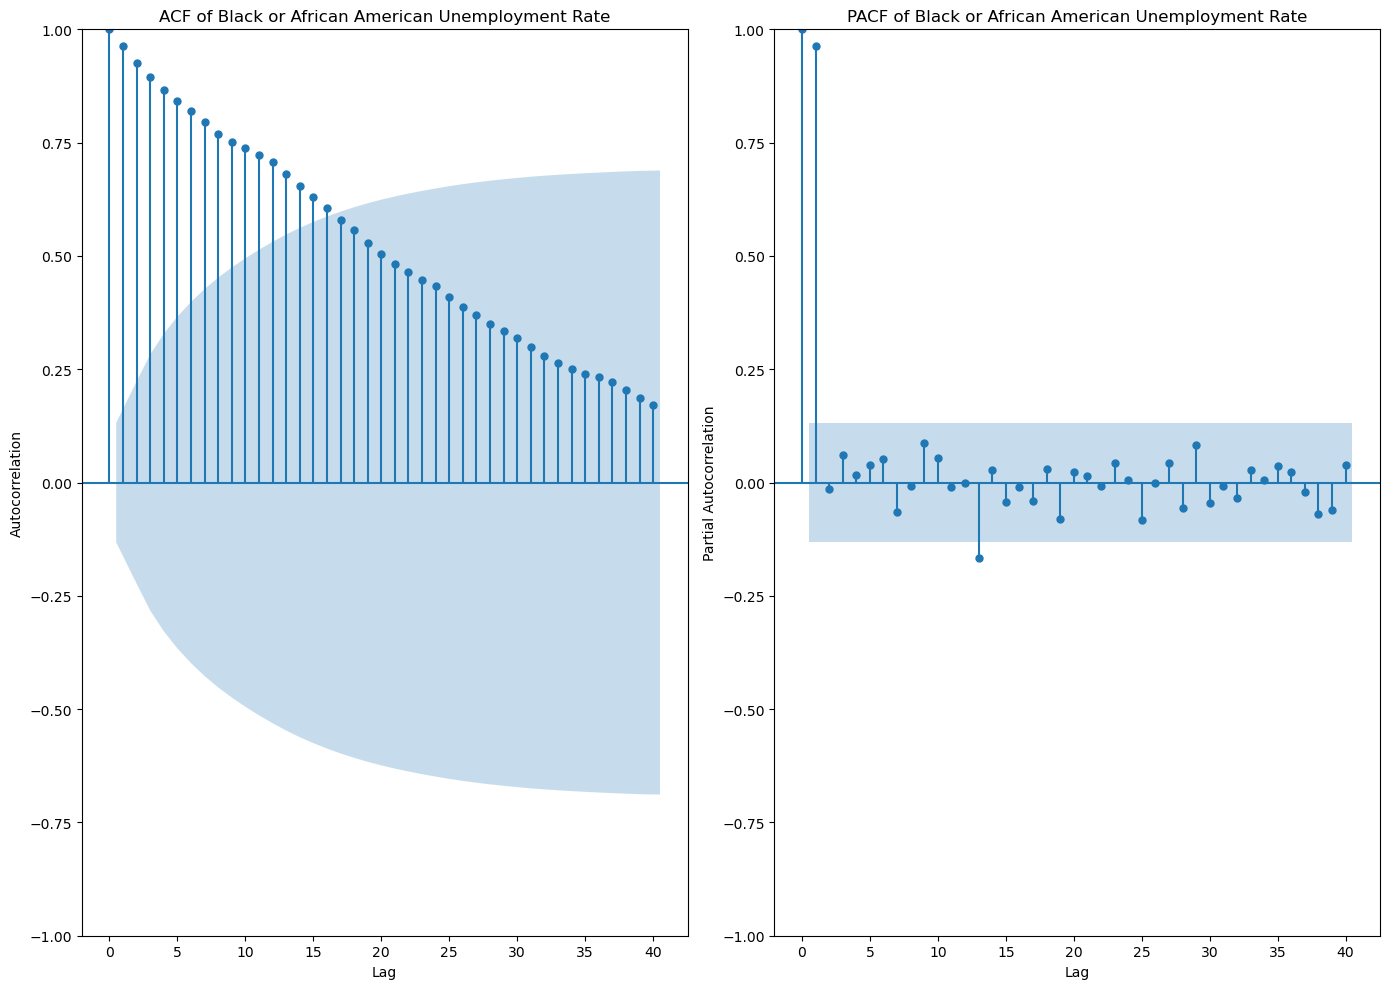


### ACF and PACF Plots for Black or African American Unemployment Rate
The ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots for the unemployment rate of the Black or African American group provide insights into the temporal dependencies in the time series data.

**ACF Plot:**
- The ACF plot shows the correlation of the time series with its own lagged values.
- It helps identify the presence of autocorrelation, indicating how past values influence current values.

**PACF Plot:**
- The PACF plot shows the correlation of the time series with its own lagged values after removing the effects of shorter lags.
- It helps identify the direct influence of past values on the current value, without the influence of intermediate lags.

**Interpretation:**
- Peaks in the ACF plot suggest significant autocorrelation at those lags, indicating that past values have a strong influence on current values.
- The PACF plot helps determine the order of an autoregressive model (AR) by showing which lags have a direct influence.

**Usage:**
- These plots are essential for identifying the appropriate parameters for time series models, such as ARIMA or SARIMA.
- They guide the selection of lag orders for autoregressive and moving average components in modeling the unemployment rate.



**Explanation of ACF and PACF Chart Axes:**

- **X-axis (Lag):**  
    The horizontal axis on both the ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) charts represents the lag, which is the number of periods (months) by which the unemployment rate series is shifted to compute correlations. For example, lag 1 compares each value to the value one month earlier, lag 2 compares to two months earlier, and so on.

- **Y-axis (Autocorrelation / Partial Autocorrelation):**  
    The vertical axis shows the correlation coefficient:
    - In the **ACF plot**, it measures the correlation between the unemployment rate and its lagged values at each lag.
    - In the **PACF plot**, it measures the correlation between the unemployment rate and its lagged values after removing the effects of shorter lags.

**What the Charts Reveal About the Data:**

- **ACF Chart:**  
    If the bars are high at low lags and gradually decrease, it indicates that the unemployment rate is highly correlated with its recent past values—showing persistence or memory in the series. Significant spikes at certain lags may indicate seasonality or cycles.

- **PACF Chart:**  
    The PACF helps identify the direct effect of a specific lag, controlling for the influence of shorter lags. A significant spike at lag 1 and then a sharp drop suggests an autoregressive process of order 1 (AR(1)), meaning the current value is mostly explained by the previous value.

**For the Black or African American unemployment rate:**
- If you see significant autocorrelation at lag 1 and possibly at seasonal lags (e.g., lag 12), it means unemployment rates are persistent and may have seasonal effects.
- The PACF can help determine the appropriate lag order for time series modeling (e.g., ARIMA).

**Summary:**  
These charts show that the unemployment rate for this group is not random but depends on its own past values, which is typical for economic time series. The patterns in the ACF and PACF help guide model selection for forecasting and understanding the underlying dynamics.


In [7]:
# ACF and PACF plots for the unemployment rate of Black or African American group
group = 'Black or African American'
series = pd.Series(df_truncated[group].values, index=df_truncated['Date'])
fig, axes = plt.subplots(1, 2, figsize=(14, 10))
plot_acf(series, lags=40, ax=axes[0], title=f'ACF of {group} Unemployment Rate')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Autocorrelation')
plot_pacf(series, lags=40, ax=axes[1], title=f'PACF of {group} Unemployment Rate')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Partial Autocorrelation')
plt.tight_layout()
plt.show()


display(Markdown("""
### ACF and PACF Plots for Black or African American Unemployment Rate
The ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots for the unemployment rate of the Black or African American group provide insights into the temporal dependencies in the time series data.
                 
**ACF Plot:**
- The ACF plot shows the correlation of the time series with its own lagged values.
- It helps identify the presence of autocorrelation, indicating how past values influence current values.
                 
**PACF Plot:**
- The PACF plot shows the correlation of the time series with its own lagged values after removing the effects of shorter lags.
- It helps identify the direct influence of past values on the current value, without the influence of intermediate lags.
                 
**Interpretation:**
- Peaks in the ACF plot suggest significant autocorrelation at those lags, indicating that past values have a strong influence on current values.
- The PACF plot helps determine the order of an autoregressive model (AR) by showing which lags have a direct influence.
                 
**Usage:**
- These plots are essential for identifying the appropriate parameters for time series models, such as ARIMA or SARIMA.
- They guide the selection of lag orders for autoregressive and moving average components in modeling the unemployment rate.
"""))

display(Markdown("""
**Explanation of ACF and PACF Chart Axes:**

- **X-axis (Lag):**  
    The horizontal axis on both the ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) charts represents the lag, which is the number of periods (months) by which the unemployment rate series is shifted to compute correlations. For example, lag 1 compares each value to the value one month earlier, lag 2 compares to two months earlier, and so on.

- **Y-axis (Autocorrelation / Partial Autocorrelation):**  
    The vertical axis shows the correlation coefficient:
    - In the **ACF plot**, it measures the correlation between the unemployment rate and its lagged values at each lag.
    - In the **PACF plot**, it measures the correlation between the unemployment rate and its lagged values after removing the effects of shorter lags.

**What the Charts Reveal About the Data:**

- **ACF Chart:**  
    If the bars are high at low lags and gradually decrease, it indicates that the unemployment rate is highly correlated with its recent past values—showing persistence or memory in the series. Significant spikes at certain lags may indicate seasonality or cycles.

- **PACF Chart:**  
    The PACF helps identify the direct effect of a specific lag, controlling for the influence of shorter lags. A significant spike at lag 1 and then a sharp drop suggests an autoregressive process of order 1 (AR(1)), meaning the current value is mostly explained by the previous value.

**For the Black or African American unemployment rate:**
- If you see significant autocorrelation at lag 1 and possibly at seasonal lags (e.g., lag 12), it means unemployment rates are persistent and may have seasonal effects.
- The PACF can help determine the appropriate lag order for time series modeling (e.g., ARIMA).

**Summary:**  
These charts show that the unemployment rate for this group is not random but depends on its own past values, which is typical for economic time series. The patterns in the ACF and PACF help guide model selection for forecasting and understanding the underlying dynamics.
"""))


# Compare Overall vs Demographic Group Unemployment Rates

Plot the overall unemployment rate alongside each demographic group's rate for direct comparison.

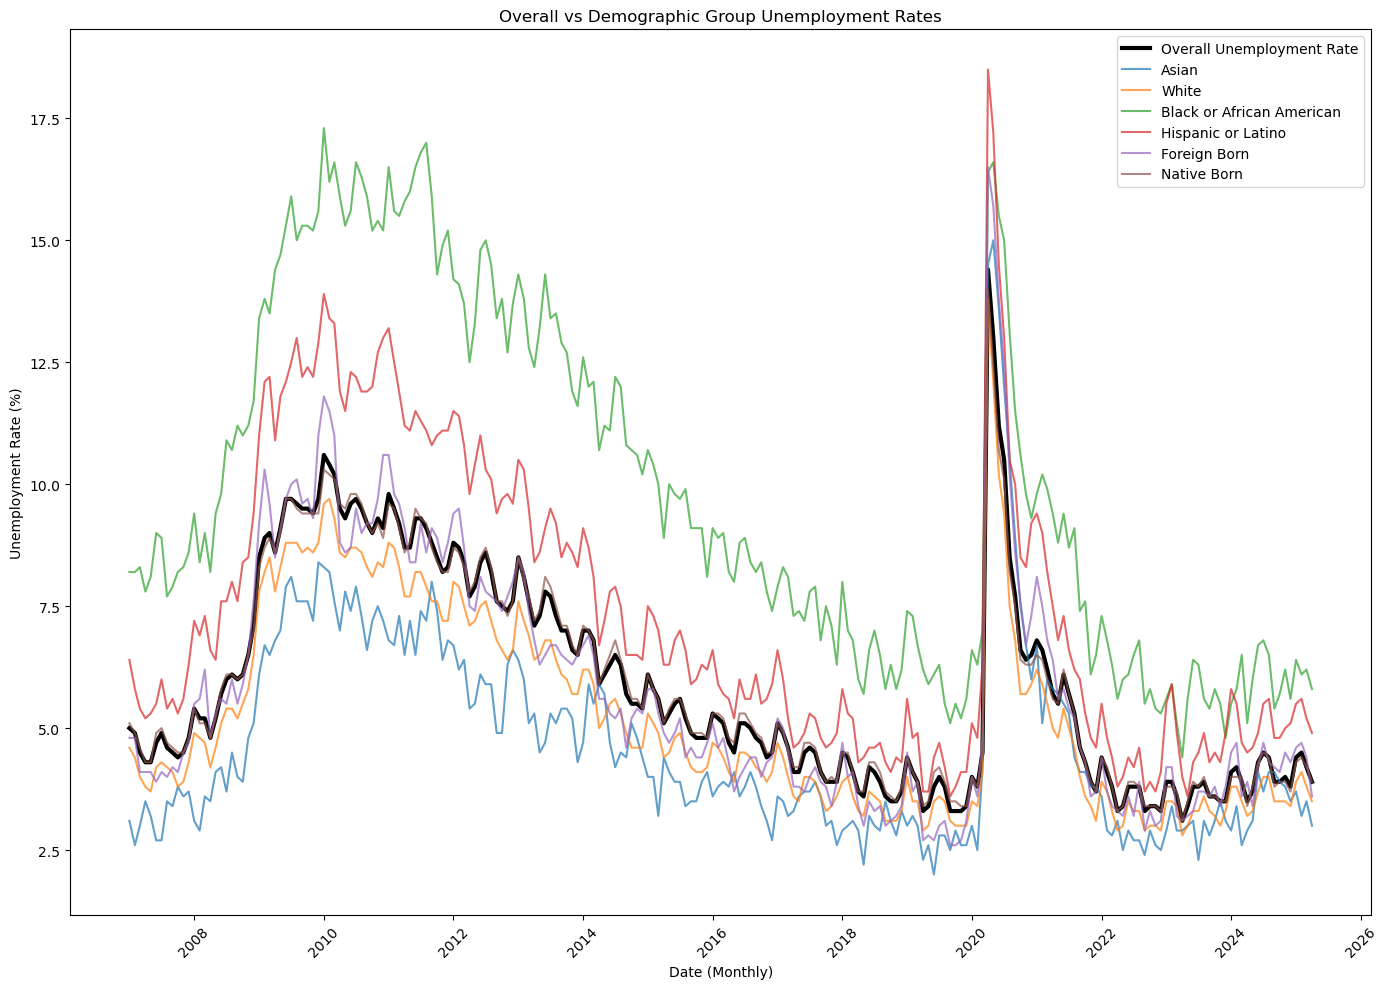


**Chart Analysis: Overall vs Demographic Group Unemployment Rates**

This chart compares the overall U.S. unemployment rate (black line) with the rates for each demographic group over time. Key observations:

- The overall unemployment rate generally falls between the rates of different demographic groups.
- Some groups, such as "Black or African American" and "Hispanic or Latino," consistently experience higher unemployment rates than the overall average.
- Other groups, like "Asian" and "White," tend to have lower unemployment rates compared to the overall rate.
- The gaps between groups persist over time, though the magnitude of these gaps can widen or narrow during economic shocks (e.g., recessions).

This visualization highlights persistent disparities in unemployment across demographic groups and how these gaps evolve through economic cycles.


In [8]:
# Plot overall unemployment rate vs each demographic group
plt.figure(figsize=(14, 10))
plt.plot(df_truncated['Date'], df_truncated['Unemployment Rate'], label='Overall Unemployment Rate', linewidth=3, color='black')

for col in clean_series_names:
    if col != 'Unemployment Rate':
        plt.plot(df_truncated['Date'], df_truncated[col], label=col, alpha=0.7)

plt.xlabel('Date (Monthly)')
plt.ylabel('Unemployment Rate (%)')
plt.title('Overall vs Demographic Group Unemployment Rates')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

display(Markdown("""
**Chart Analysis: Overall vs Demographic Group Unemployment Rates**

This chart compares the overall U.S. unemployment rate (black line) with the rates for each demographic group over time. Key observations:

- The overall unemployment rate generally falls between the rates of different demographic groups.
- Some groups, such as "Black or African American" and "Hispanic or Latino," consistently experience higher unemployment rates than the overall average.
- Other groups, like "Asian" and "White," tend to have lower unemployment rates compared to the overall rate.
- The gaps between groups persist over time, though the magnitude of these gaps can widen or narrow during economic shocks (e.g., recessions).

This visualization highlights persistent disparities in unemployment across demographic groups and how these gaps evolve through economic cycles.
"""))

# Trend Analysis: Linear Regression and LOESS

Fit and plot linear regression and LOESS smoothed trends for each demographic group to analyze long-term changes.

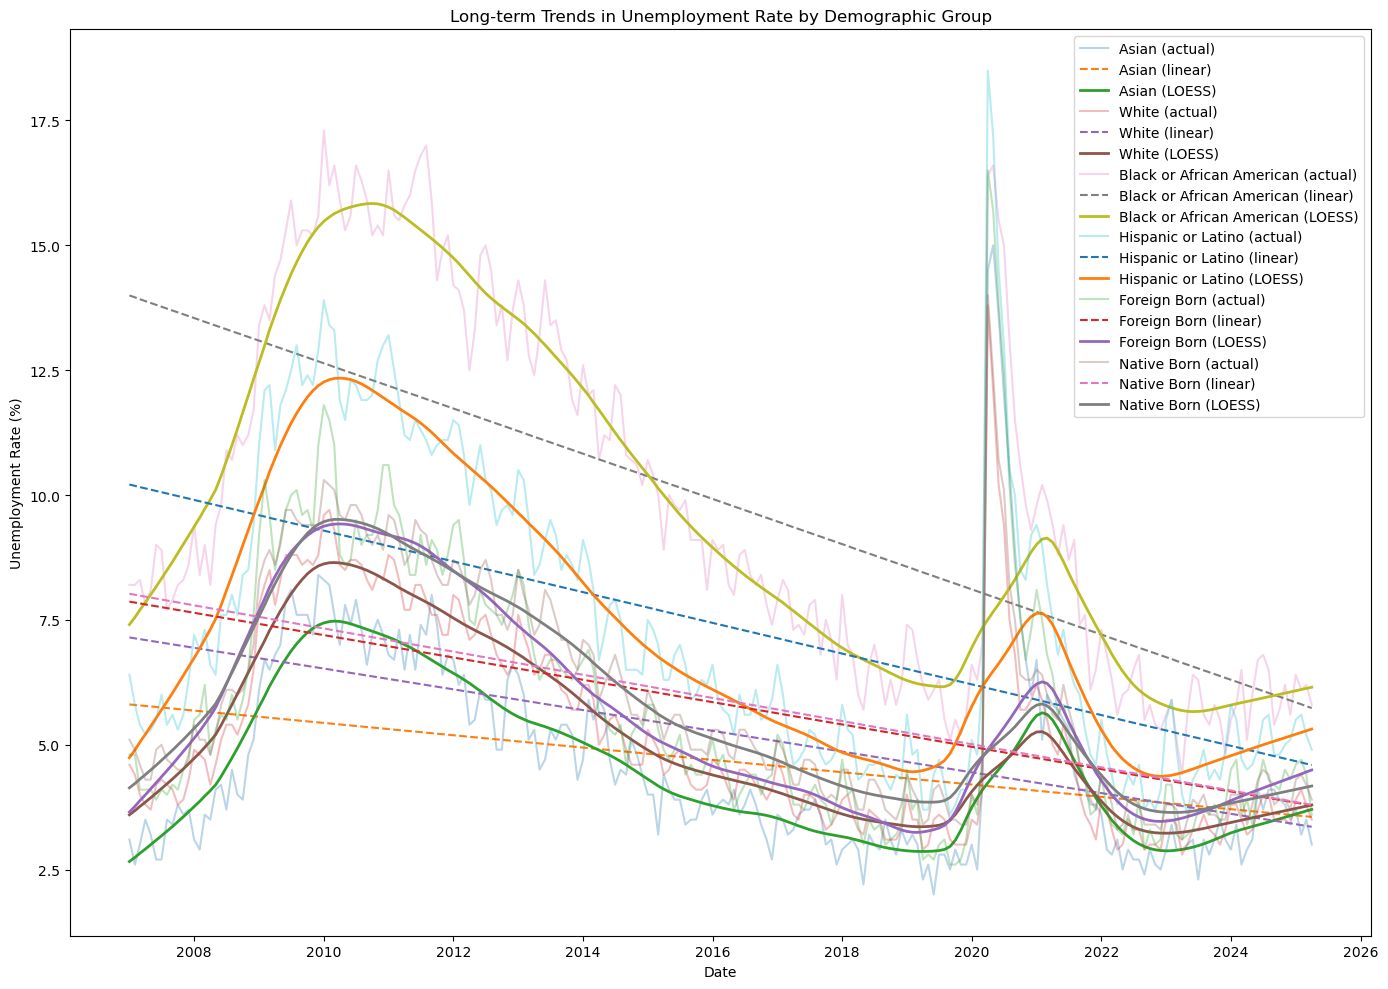


### Long-term Trends in Unemployment Rate by Demographic Group

**Trend Comparison Chart:**  
  For each demographic group, the chart shows:
  - The actual unemployment rate (faint line).
  - The long-term linear trend (dashed line), estimated using linear regression.
  - The smoothed trend (solid line), estimated using LOESS (locally weighted regression).
  - Compare the slopes and shapes: a steeper upward slope indicates worsening unemployment for that group over time, while a downward slope suggests improvement. LOESS reveals non-linear trends and cycles.




**How the models are used:**

- **Linear Regression:** Fits a straight line to each group's unemployment rate over time, summarizing the overall direction (increase/decrease) of unemployment for that group.
- **LOESS Smoothing:** Captures non-linear trends and cyclical patterns, providing a flexible fit that adapts to local changes in the data.

**How to interpret the charts:**

- Look for groups with consistently higher gaps or ratios—these indicate persistent disadvantage.
- Observe whether gaps are widening or narrowing over time, especially during recessions or recoveries.
- Use the linear and LOESS trends to distinguish between long-term structural changes and short-term fluctuations.


In [9]:


# Long-term trend comparison using linear regression and LOESS for each group

plt.figure(figsize=(14, 10))
for col in clean_series_names:
    if col == 'Unemployment Rate':
        continue
    # Prepare data
    x = np.arange(len(df_truncated))
    y = df_truncated[col].values
    # Linear Regression
    lr = LinearRegression()
    lr.fit(x.reshape(-1, 1), y)
    y_pred = lr.predict(x.reshape(-1, 1))
    # LOESS smoothing
    loess_smoothed = lowess(y, x, frac=0.15, return_sorted=False)
    # Plot
    plt.plot(df_truncated['Date'], y, label=f"{col} (actual)", alpha=0.3)
    plt.plot(df_truncated['Date'], y_pred, label=f"{col} (linear)", linestyle='--')
    plt.plot(df_truncated['Date'], loess_smoothed, label=f"{col} (LOESS)", linewidth=2)
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.title('Long-term Trends in Unemployment Rate by Demographic Group')
plt.legend()
plt.tight_layout()
plt.show()

display(Markdown(
"""
### Long-term Trends in Unemployment Rate by Demographic Group

**Trend Comparison Chart:**  
  For each demographic group, the chart shows:
  - The actual unemployment rate (faint line).
  - The long-term linear trend (dashed line), estimated using linear regression.
  - The smoothed trend (solid line), estimated using LOESS (locally weighted regression).
  - Compare the slopes and shapes: a steeper upward slope indicates worsening unemployment for that group over time, while a downward slope suggests improvement. LOESS reveals non-linear trends and cycles.
"""
))

display(Markdown(
    """

**How the models are used:**

- **Linear Regression:** Fits a straight line to each group's unemployment rate over time, summarizing the overall direction (increase/decrease) of unemployment for that group.
- **LOESS Smoothing:** Captures non-linear trends and cyclical patterns, providing a flexible fit that adapts to local changes in the data.

**How to interpret the charts:**

- Look for groups with consistently higher gaps or ratios—these indicate persistent disadvantage.
- Observe whether gaps are widening or narrowing over time, especially during recessions or recoveries.
- Use the linear and LOESS trends to distinguish between long-term structural changes and short-term fluctuations.
"""
))

# Unemployment Gap and Ratio Analysis

Calculate and plot the unemployment rate gap and ratio between each group and the White group.

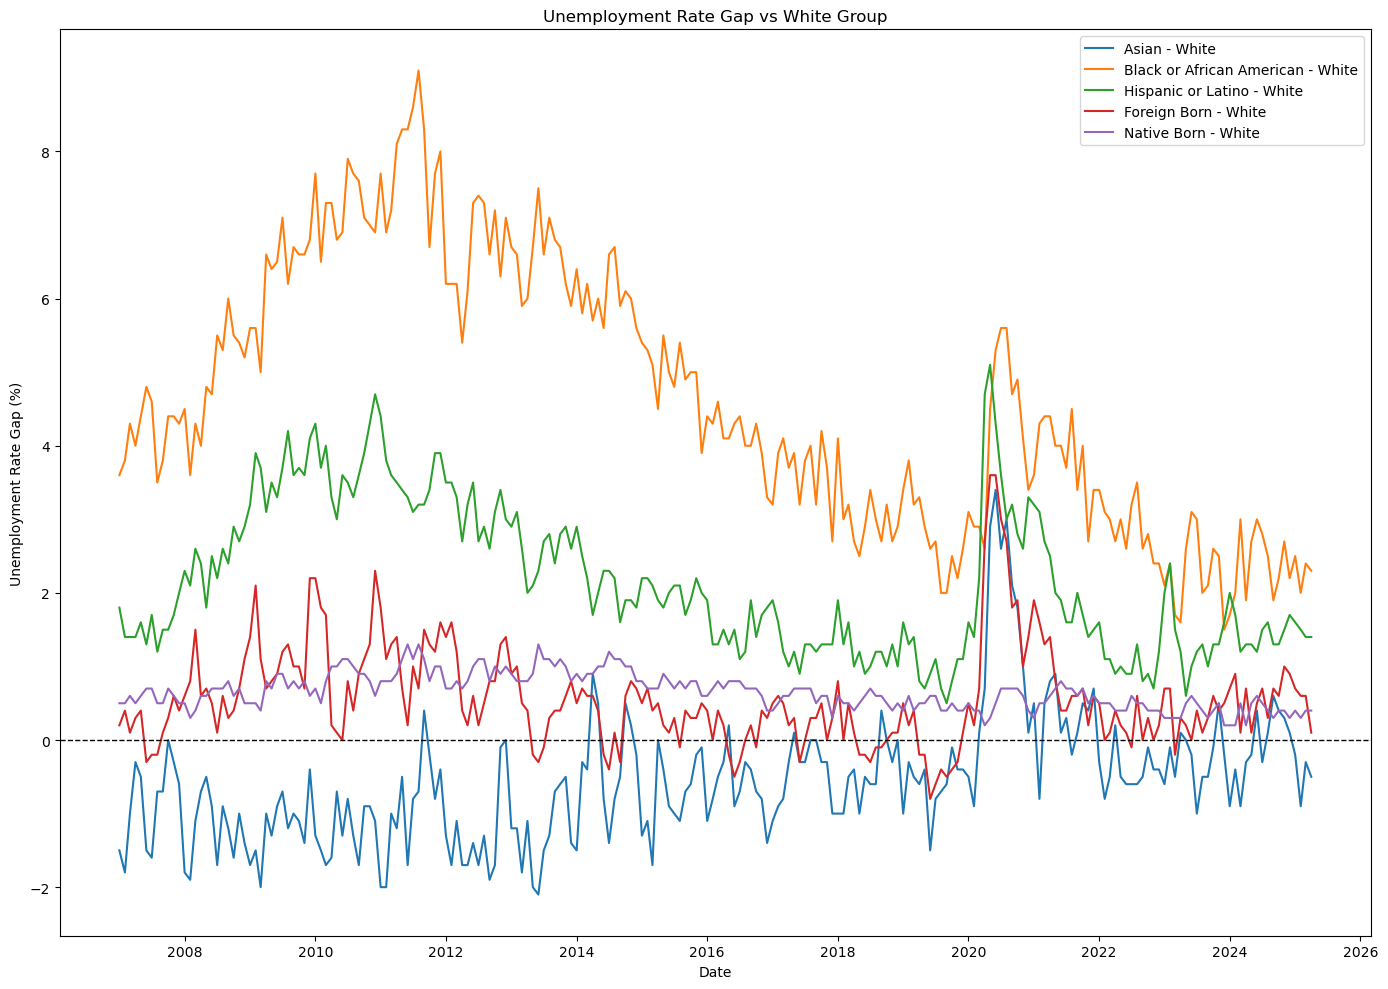

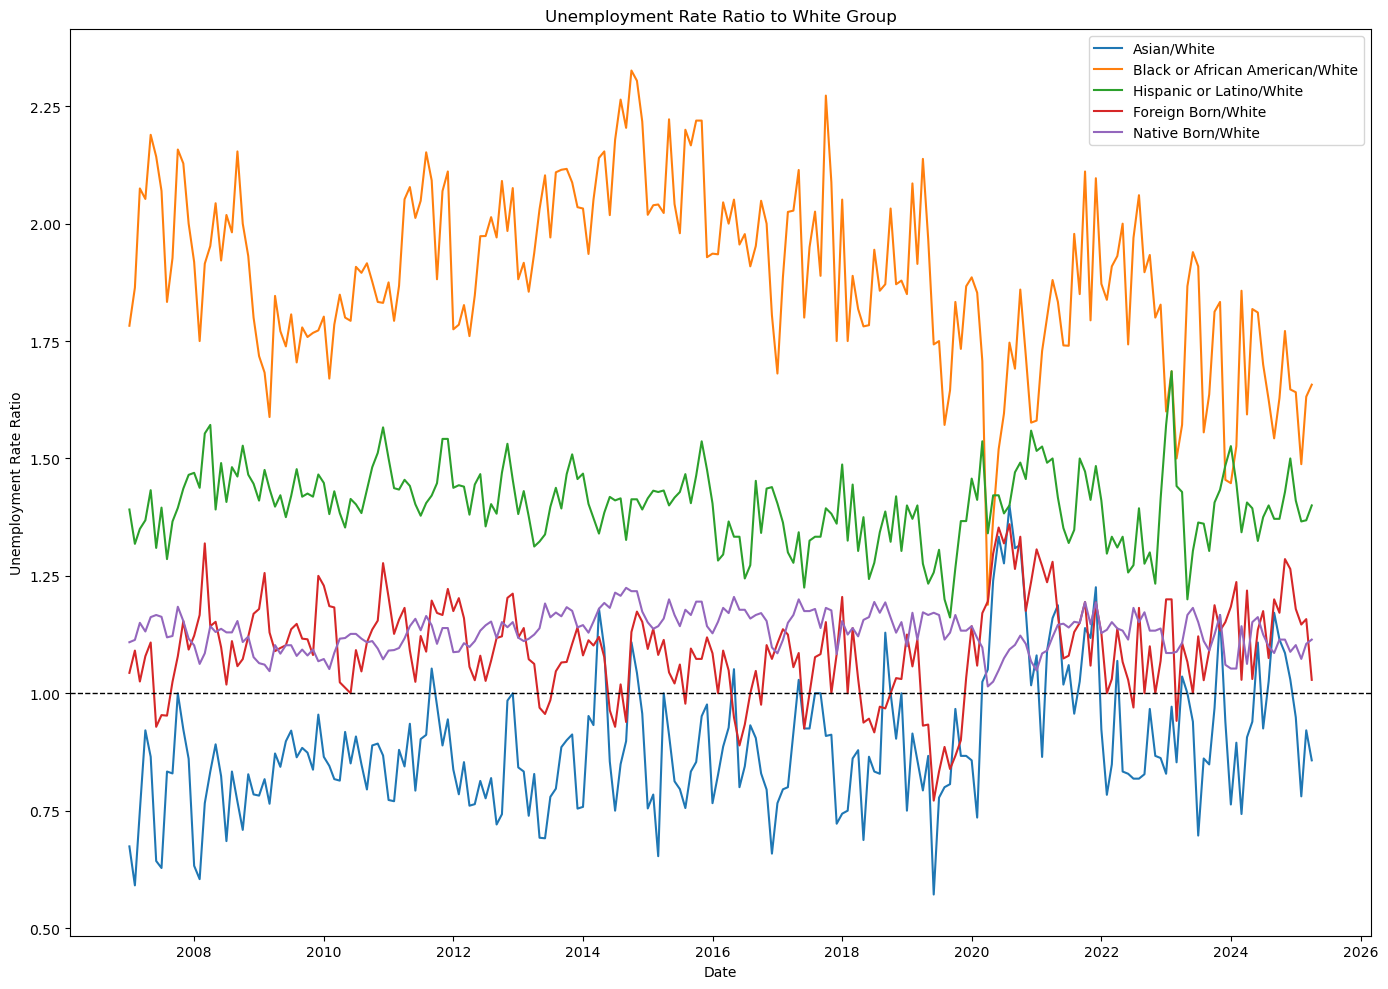


**Gap and Ratio Charts:**  
  These charts compare each group to the "White" group:
  - **Gap Chart:** Shows the difference in unemployment rate (group minus White). Values above zero mean the group has higher unemployment than White; below zero means lower.
  - **Ratio Chart:** Shows the unemployment rate as a ratio to White. Values above 1 mean higher unemployment relative to White; below 1 means lower.
  - Persistent gaps or ratios above 1 highlight structural disparities.



---

### Chart Analysis and Next Steps

**Analysis:**  
The gap and ratio charts provide a clear visualization of structural disparities in unemployment rates between demographic groups and the White population. Persistent positive gaps and ratios above 1 for groups such as "Black or African American" and "Hispanic or Latino" indicate long-standing disadvantages in the labor market. Conversely, groups with gaps below zero or ratios below 1, such as "Asian," often experience lower unemployment rates than the White group. The temporal evolution of these metrics also reveals how economic shocks (e.g., recessions, pandemics) can widen or narrow these disparities.

**Next Steps to Enhance the Research:**
- **Statistical Testing:** Apply statistical tests (e.g., t-tests, time series regression) to formally assess the significance and persistence of gaps over time.
- **Policy/Event Overlay:** Overlay major policy changes, economic events, or presidential terms on the charts to contextualize shifts in gaps and ratios.
- **Decomposition by Age/Education:** Further break down unemployment gaps by age, education, or region to uncover intersectional disparities.
- **Forecasting Gaps:** Use time series models to forecast future gaps and ratios, helping anticipate which groups may be most vulnerable in upcoming downturns.
- **Causal Analysis:** Explore causal inference methods to identify drivers of unemployment disparities, such as discrimination, industry composition, or access to education.
- **Interactive Visualization:** Develop interactive dashboards to allow users to explore gaps and ratios by group, time period, or event.

By extending the analysis in these directions, the research can provide deeper insights into the causes and consequences of labor market inequality, and inform more targeted policy interventions.


In [10]:
# Unemployment gap analysis: difference and ratio to White group
reference_group = 'White'
gaps = {}
ratios = {}
for col in clean_series_names:
    if col in ['Unemployment Rate', reference_group]:
        continue
    gaps[col] = df_truncated[col] - df_truncated[reference_group]
    ratios[col] = df_truncated[col] / df_truncated[reference_group]

# Plot unemployment gaps
plt.figure(figsize=(14, 10))
for col, gap in gaps.items():
    plt.plot(df_truncated['Date'], gap, label=f"{col} - {reference_group}")
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Unemployment Rate Gap (%)')
plt.title('Unemployment Rate Gap vs White Group')
plt.legend()
plt.tight_layout()
plt.show()

# Plot unemployment ratios
plt.figure(figsize=(14, 10))
for col, ratio in ratios.items():
    plt.plot(df_truncated['Date'], ratio, label=f"{col}/{reference_group}")
plt.axhline(1, color='black', linestyle='--', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Unemployment Rate Ratio')
plt.title('Unemployment Rate Ratio to White Group')
plt.legend()
plt.tight_layout()
plt.show()

display(Markdown(
"""
**Gap and Ratio Charts:**  
  These charts compare each group to the "White" group:
  - **Gap Chart:** Shows the difference in unemployment rate (group minus White). Values above zero mean the group has higher unemployment than White; below zero means lower.
  - **Ratio Chart:** Shows the unemployment rate as a ratio to White. Values above 1 mean higher unemployment relative to White; below 1 means lower.
  - Persistent gaps or ratios above 1 highlight structural disparities.
"""
))

display(Markdown(
"""
---

### Chart Analysis and Next Steps

**Analysis:**  
The gap and ratio charts provide a clear visualization of structural disparities in unemployment rates between demographic groups and the White population. Persistent positive gaps and ratios above 1 for groups such as "Black or African American" and "Hispanic or Latino" indicate long-standing disadvantages in the labor market. Conversely, groups with gaps below zero or ratios below 1, such as "Asian," often experience lower unemployment rates than the White group. The temporal evolution of these metrics also reveals how economic shocks (e.g., recessions, pandemics) can widen or narrow these disparities.

**Next Steps to Enhance the Research:**
- **Statistical Testing:** Apply statistical tests (e.g., t-tests, time series regression) to formally assess the significance and persistence of gaps over time.
- **Policy/Event Overlay:** Overlay major policy changes, economic events, or presidential terms on the charts to contextualize shifts in gaps and ratios.
- **Decomposition by Age/Education:** Further break down unemployment gaps by age, education, or region to uncover intersectional disparities.
- **Forecasting Gaps:** Use time series models to forecast future gaps and ratios, helping anticipate which groups may be most vulnerable in upcoming downturns.
- **Causal Analysis:** Explore causal inference methods to identify drivers of unemployment disparities, such as discrimination, industry composition, or access to education.
- **Interactive Visualization:** Develop interactive dashboards to allow users to explore gaps and ratios by group, time period, or event.

By extending the analysis in these directions, the research can provide deeper insights into the causes and consequences of labor market inequality, and inform more targeted policy interventions.
"""
))


# SARIMA and VAR Forecasting

Fit SARIMA to the overall unemployment rate and VAR to selected groups, then plot forecasts.

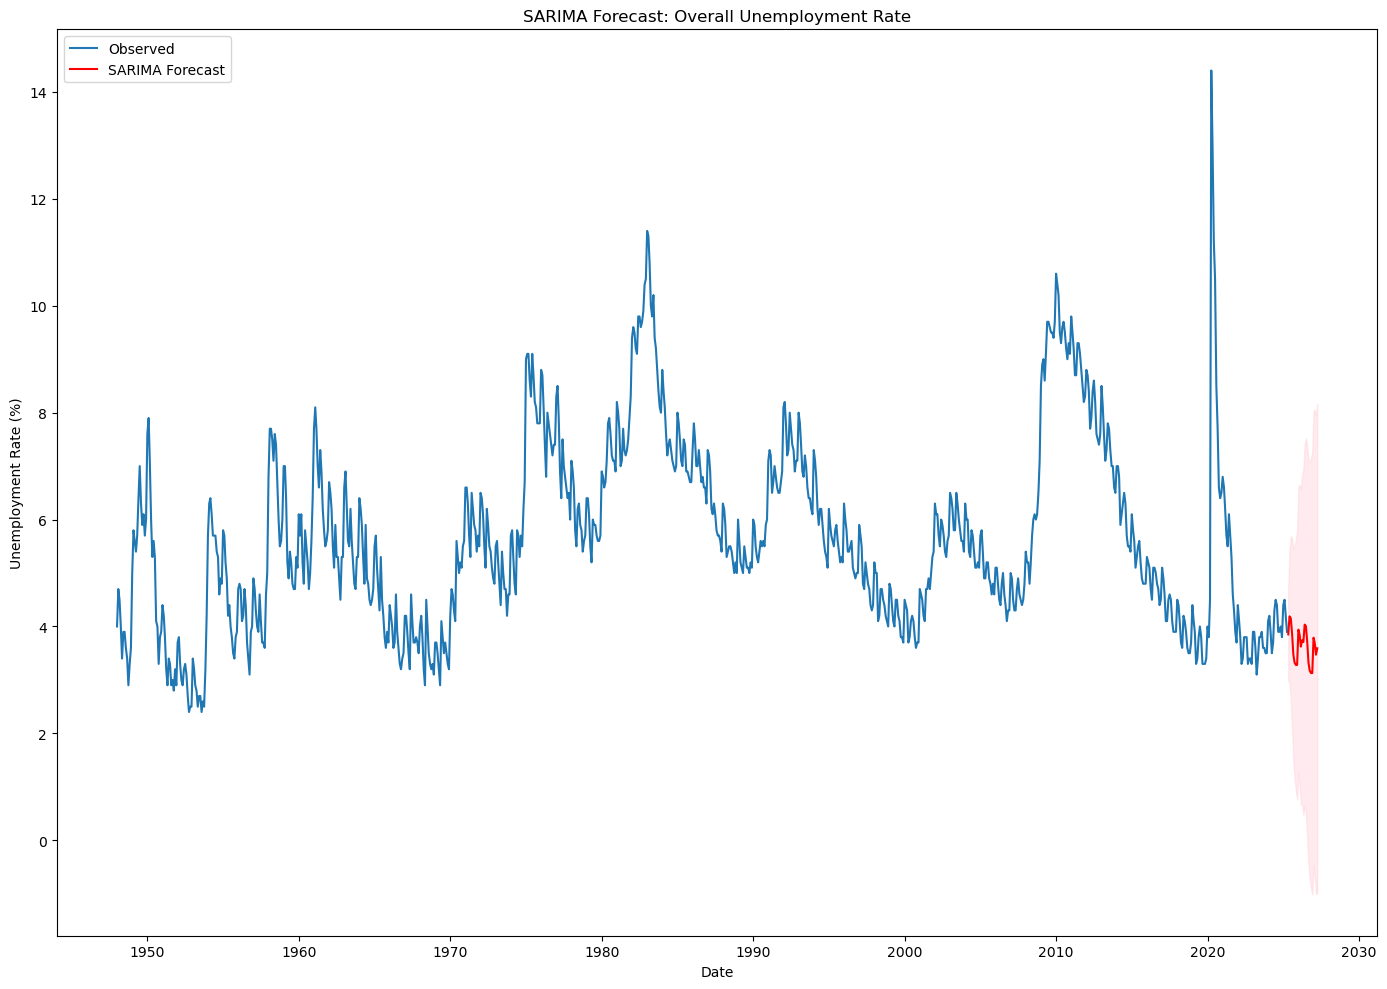

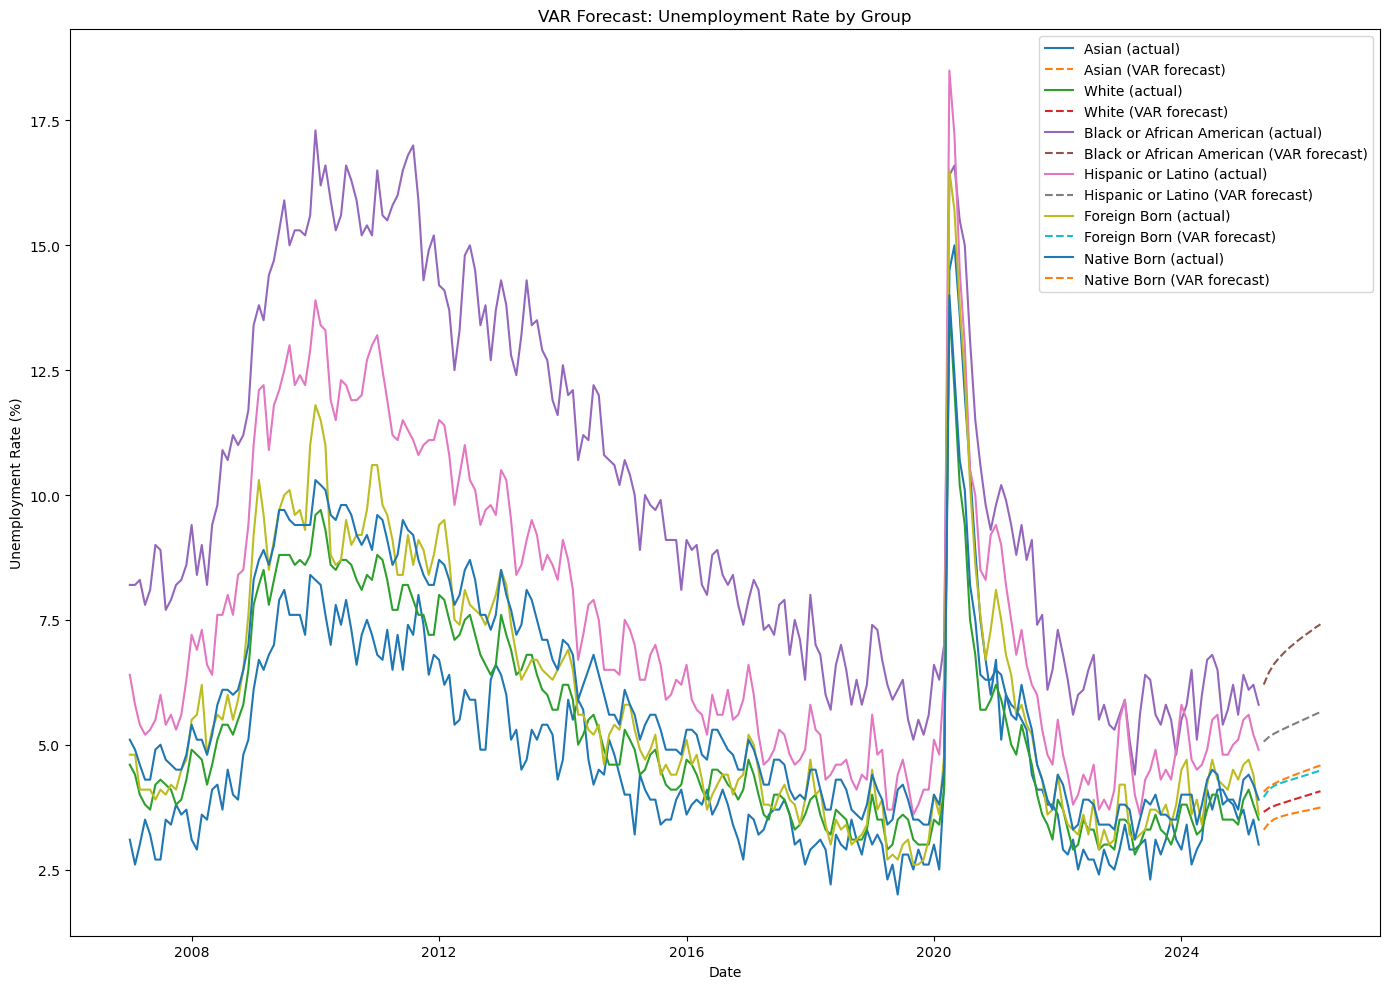

In [13]:
# --- SARIMA Forecast: Overall Unemployment Rate ---
series_unemp = df_unemployment.set_index('Date')['Unemployment Rate']
series_unemp.index = pd.to_datetime(series_unemp.index)
series_unemp = series_unemp.asfreq('MS')

# Fit SARIMA model (order can be tuned as needed)
sarima_model = SARIMAX(series_unemp, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit(disp=False)

forecast_periods = 24
sarima_forecast = sarima_result.get_forecast(steps=forecast_periods)
forecast_index = pd.date_range(series_unemp.index[-1] + pd.offsets.MonthBegin(1), periods=forecast_periods, freq='MS')
forecast_mean = sarima_forecast.predicted_mean
forecast_ci = sarima_forecast.conf_int(alpha=0.05)
forecast_ci.index = forecast_index
forecast_mean.index = forecast_index

plt.figure(figsize=(14, 10))
plt.plot(series_unemp, label='Observed')
plt.plot(forecast_mean.index, forecast_mean.values, label='SARIMA Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA Forecast: Overall Unemployment Rate')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.tight_layout()
plt.show()

# --- VAR Forecast: Unemployment Rate by Group ---
var_data = df_truncated.set_index('Date')[
    ['Asian', 'White', 'Black or African American', 'Hispanic or Latino', 'Foreign Born', 'Native Born']
]
var_data.index = pd.to_datetime(var_data.index)
var_data = var_data.asfreq('MS')

var_model = VAR(var_data)
var_result = var_model.fit(maxlags=12, ic='aic')
var_forecast_periods = 12
var_forecast = var_result.forecast(var_data.values[-var_result.k_ar:], steps=var_forecast_periods)
var_forecast_index = pd.date_range(var_data.index[-1] + pd.offsets.MonthBegin(1), periods=var_forecast_periods, freq='MS')
var_forecast_df = pd.DataFrame(var_forecast, index=var_forecast_index, columns=var_data.columns)

plt.figure(figsize=(14, 10))
for col in var_data.columns:
    plt.plot(var_data.index, var_data[col], label=f"{col} (actual)")
    plt.plot(var_forecast_df.index, var_forecast_df[col], '--', label=f"{col} (VAR forecast)")
plt.title('VAR Forecast: Unemployment Rate by Group')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.tight_layout()
plt.show()

# Change Point Detection

Detect and plot structural breaks in the overall unemployment rate using the PELT algorithm.

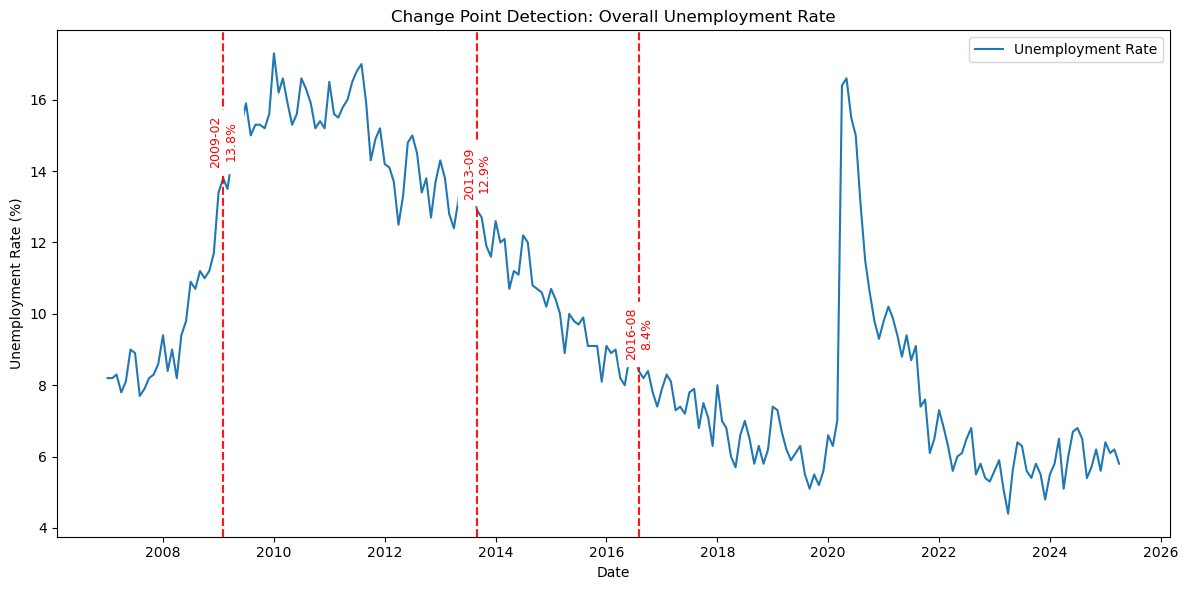


**Change Point Detection: Overall Unemployment Rate**

Red dashed lines indicate detected structural breaks in the unemployment rate time series.
- These change points often correspond to major economic events, such as recessions or the COVID-19 pandemic.
- The most prominent breaks align with known periods of economic stress, where the unemployment rate shifts to a new level or trend.

**Interpretation:**  
Change point analysis reveals that the unemployment rate does not evolve smoothly, but rather in distinct regimes separated by economic shocks. Recognizing these breaks is crucial for understanding labor market dynamics and for improving the accuracy of forecasting models.
    

In [ ]:
# --- Change Point Detection: Overall Unemployment Rate ---
penalty_value = 10  # You can adjust this value as needed

algo = rpt.Pelt(model='rbf').fit(series.values)
result = algo.predict(pen=penalty_value)

plt.figure(figsize=(14, 10))
plt.plot(series.index, series.values, label='Unemployment Rate')
for cp in result[:-1]:  # exclude the last point (end of series)
    date = series.index[cp]
    value = series.iloc[cp]
    plt.axvline(date, color='red', linestyle='--', alpha=0.7)
    plt.text(
        date, value + 0.3,  # slightly above the point
        f"{date.strftime('%Y-%m')}\n{value:.1f}%",
        color='red', fontsize=9, rotation=90, va='bottom', ha='center', backgroundcolor='white'
    )
    plt.axvline(series.index[cp], color='red', linestyle='--', alpha=0.7)
plt.title('Change Point Detection: Overall Unemployment Rate')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.tight_layout()
plt.show()

display(Markdown(
    """
**Change Point Detection: Overall Unemployment Rate**

Red dashed lines indicate detected structural breaks in the unemployment rate time series.
- These change points often correspond to major economic events, such as recessions or the COVID-19 pandemic.
- The most prominent breaks align with known periods of economic stress, where the unemployment rate shifts to a new level or trend.

**Interpretation:**  
Change point analysis reveals that the unemployment rate does not evolve smoothly, but rather in distinct regimes separated by economic shocks. Recognizing these breaks is crucial for understanding labor market dynamics and for improving the accuracy of forecasting models.
    """
)) 

# Change Point Detection with Policy Headlines

Annotate detected change points with policy headlines from a summary file for context.

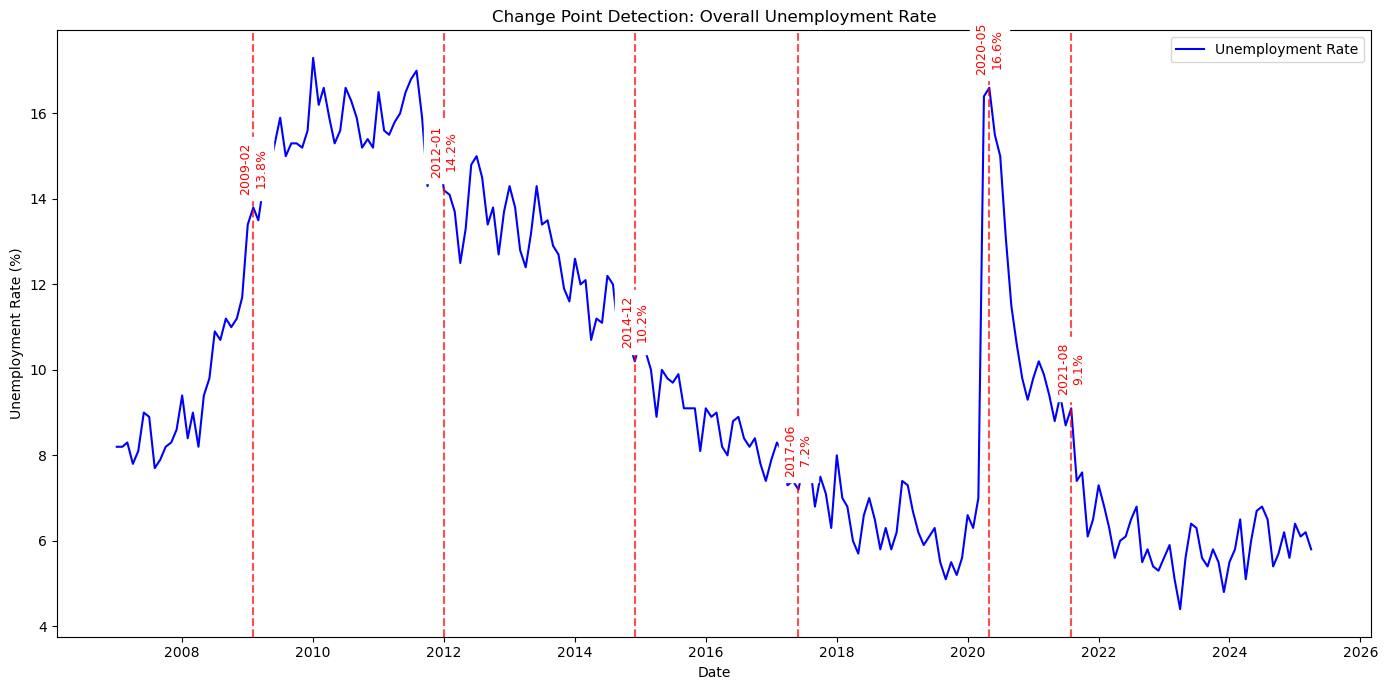


**What does this chart show?**

This chart displays the U.S. unemployment rate over time, with red dashed lines and labels indicating detected change points. Each label shows the date and unemployment rate at the change point, helping you research major economic events or policy changes that may have caused these shifts.

**How are the change points calculated?**

Change points are detected using the PELT (Pruned Exact Linear Time) algorithm from the `ruptures` library, with the "rbf" (radial basis function) cost model. This method identifies points in the time series where the mean and/or variance changes significantly, indicating a structural break. The algorithm works by minimizing a cost function that balances the fit of the model with the number of change points, using a penalty parameter to avoid overfitting. The detected change points highlight moments where the statistical properties of the unemployment rate shifted, often due to economic shocks or policy interventions.

**Change in Model: Reduced Penalty for Change Point Detection**

The change point detection model was re-run with a lower penalty value (`pen={penalty_value}`), making the algorithm more sensitive to changes in the unemployment rate time series.  
- **Lower penalty** means the model is more likely to detect additional change points, including smaller or more subtle shifts in the data.
- This can help reveal more nuanced structural breaks, but may also increase the risk of detecting noise as change points.

**Interpretation:**  
Compare the new chart to the previous one to see if more change points are detected. If so, these may correspond to less dramatic but still meaningful changes in the unemployment rate, or they may reflect short-term fluctuations rather than major economic events.


In [ ]:
# Reduce the penalty parameter (e.g., from 10 to 5, or lower if previously higher)
penalty_value = 5  # You can adjust this value as needed

# Run change point detection again with reduced penalty
algo = rpt.Pelt(model='rbf').fit(series.values)
result = algo.predict(pen=penalty_value)



# Plot change point detection with labels for each change point (date and percentage)
plt.figure(figsize=(14, 10))
plt.plot(series.index, series.values, label='Unemployment Rate', color='blue')

for cp in result[:-1]:  # exclude the last point (end of series)
    date = series.index[cp]
    value = series.iloc[cp]
    plt.axvline(date, color='red', linestyle='--', alpha=0.7)
    plt.text(
        date, value + 0.3,  # slightly above the point
        f"{date.strftime('%Y-%m')}\n{value:.1f}%",
        color='red', fontsize=9, rotation=90, va='bottom', ha='center', backgroundcolor='white'
    )

plt.title('Change Point Detection: Overall Unemployment Rate')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.tight_layout()
plt.show()

display(Markdown(
    """
**What does this chart show?**

This chart displays the U.S. unemployment rate over time, with red dashed lines and labels indicating detected change points. Each label shows the date and unemployment rate at the change point, helping you research major economic events or policy changes that may have caused these shifts.

**How are the change points calculated?**

Change points are detected using the PELT (Pruned Exact Linear Time) algorithm from the `ruptures` library, with the "rbf" (radial basis function) cost model. This method identifies points in the time series where the mean and/or variance changes significantly, indicating a structural break. The algorithm works by minimizing a cost function that balances the fit of the model with the number of change points, using a penalty parameter to avoid overfitting. The detected change points highlight moments where the statistical properties of the unemployment rate shifted, often due to economic shocks or policy interventions.

**Change in Model: Reduced Penalty for Change Point Detection**

The change point detection model was re-run with a lower penalty value (`pen={penalty_value}`), making the algorithm more sensitive to changes in the unemployment rate time series.  
- **Lower penalty** means the model is more likely to detect additional change points, including smaller or more subtle shifts in the data.
- This can help reveal more nuanced structural breaks, but may also increase the risk of detecting noise as change points.

**Interpretation:**  
Compare the new chart to the previous one to see if more change points are detected. If so, these may correspond to less dramatic but still meaningful changes in the unemployment rate, or they may reflect short-term fluctuations rather than major economic events.
"""
))


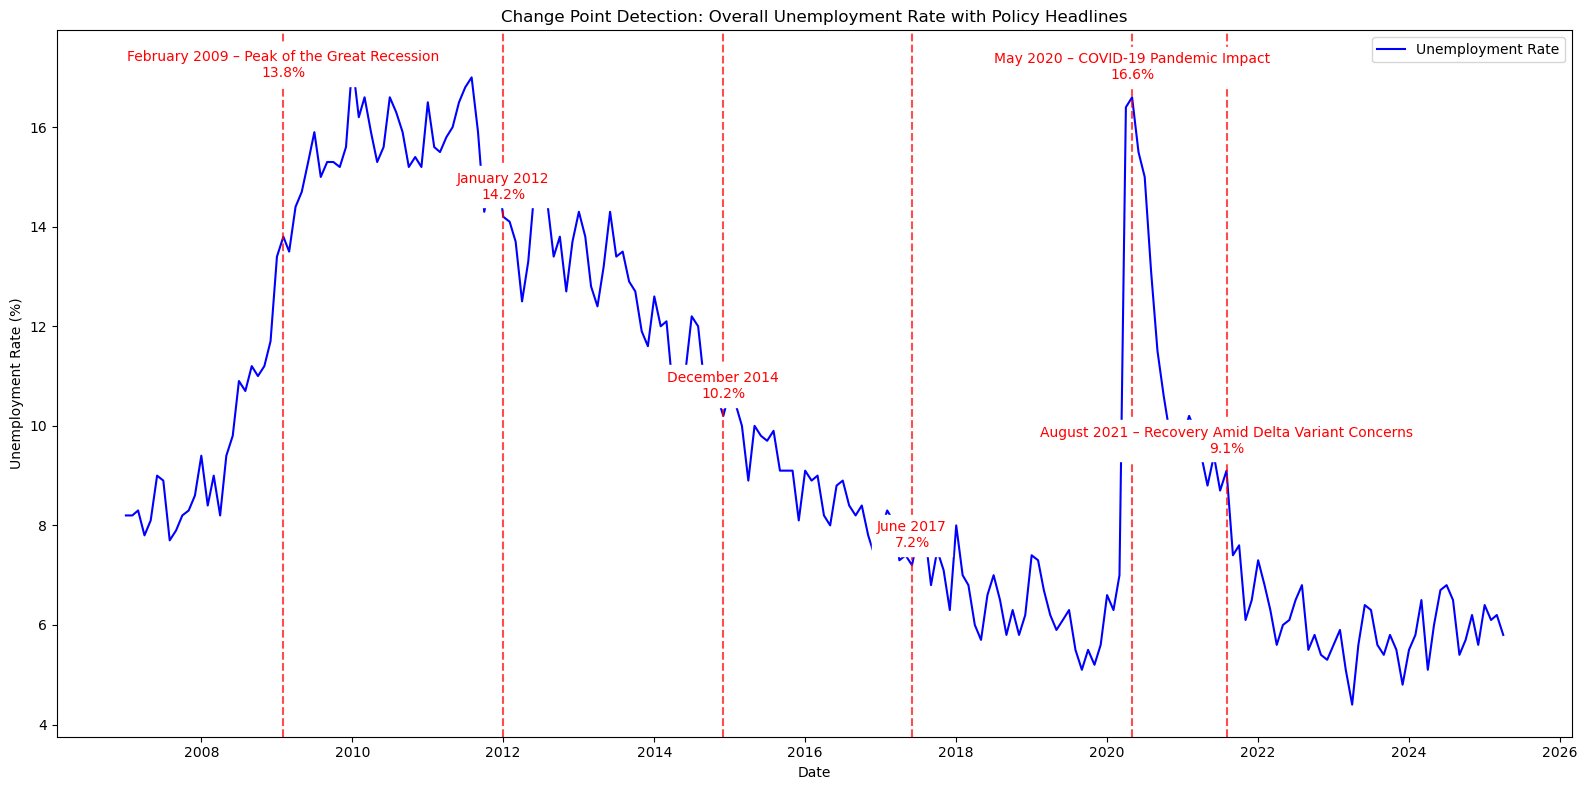

In [ ]:
# Read date-headline pairs from the summary file (format: "Month YYYY – Headline")
headline_map = {}
with open("data/Policy_Changes_Unemployment_Summary.txt", "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line or "–" not in line:
            continue
        date_part, headline = line.split("–", 1)
        date_part = date_part.strip()
        headline = headline.strip()
        try:
            # Parse date as "Month YYYY"
            date_key = pd.to_datetime(date_part).to_period("M").to_timestamp()
            headline_map[date_key] = headline
        except Exception:
            continue

# Plot change point detection with horizontal, non-overlapping labels including headlines and unemployment rate
plt.figure(figsize=(14, 10))
plt.plot(series.index, series.values, label='Unemployment Rate', color='blue')

label_positions = []
min_vgap = 3  # Minimum vertical gap between labels

for i, cp in enumerate(result[:-1]):  # exclude the last point (end of series)
    date = series.index[cp]
    value = series.iloc[cp]
    date_key = date.to_period("M").to_timestamp()
    headline = headline_map.get(date_key, "")
    # Label format: "Feb 2009 – Peak of the Great Recession\n8.7%"
    label = f"{date.strftime('%B %Y')}"
    if headline:
        label += f" – {headline}"
    label += f"\n{value:.1f}%"

    # For the first label, place it at the top of the chart
    if i == 0:
        y_pos = plt.ylim()[1] - 1  # 1 unit below the top
    else:
        y_pos = value + 0.3
        for prev_x, prev_y in label_positions:
            if abs((date - prev_x).days) < 20 and abs(y_pos - prev_y) < min_vgap:
                y_pos = prev_y + min_vgap
    label_positions.append((date, y_pos))

    plt.axvline(date, color='red', linestyle='--', alpha=0.7)
    plt.text(
        date, y_pos,
        label,
        color='red', fontsize=10, rotation=0, va='bottom', ha='center', backgroundcolor='white'
    )

plt.title('Change Point Detection: Overall Unemployment Rate with Policy Headlines')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.tight_layout()
plt.show()



# Anomaly Detection with Isolation Forest

Apply Isolation Forest to detect and plot anomalies in the unemployment rate time series.

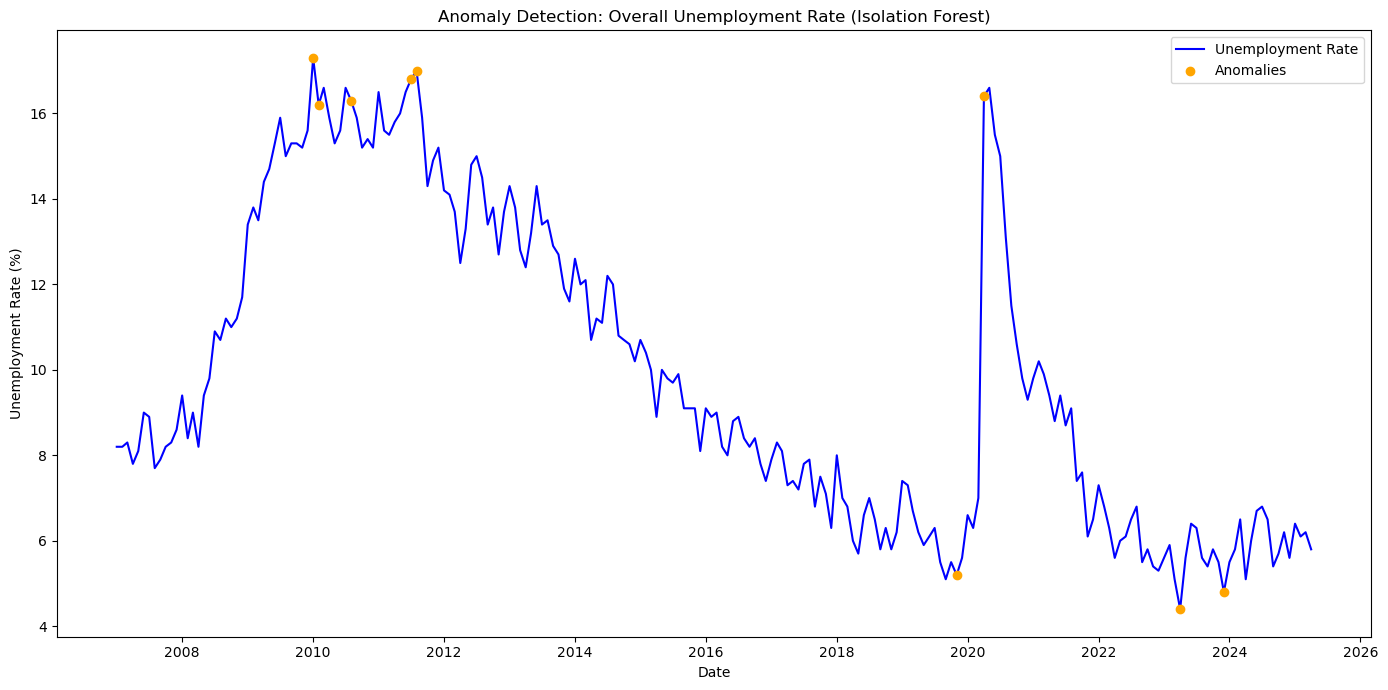



**Anomaly Detection vs Change Point Detection**

- **Anomaly Detection (Isolation Forest):**  
  Orange points show months where the unemployment rate is unusually high or low compared to the rest of the series.  
  This method highlights outliers, such as sudden spikes or drops, rather than persistent shifts in trend.

- **Change Point Detection:**  
  Previously, red dashed lines indicated structural breaks—points where the statistical properties of the series change.

**Comparison:**  
- Anomaly detection is useful for identifying rare, extreme events (outliers).
- Change point detection finds regime shifts or persistent changes in the data's behavior.
- Use both methods together to get a fuller picture of both sudden shocks and longer-term transitions in the unemployment rate.
### How Does Isolation Forest Detect Anomalies?

**Isolation Forest** is an unsupervised machine learning algorithm designed specifically for anomaly (outlier) detection in high-dimensional datasets. It works as follows:

- **Isolation Principle:**  
  Anomalies are data points that are few and different. They are easier to "isolate" from the rest of the data compared to normal points.

- **How It Works:**  
  1. The algorithm builds an ensemble of random decision trees (isolation trees).
  2. Each tree is constructed by randomly selecting a feature and then randomly choosing a split value between the minimum and maximum values of that feature.
  3. This process recursively partitions the data until each point is isolated in its own leaf node.
  4. The number of splits required to isolate a point is called its "path length."
  5. **Anomalies** tend to have shorter average path lengths across the trees, because they are more likely to be separated early due to their distinctiveness.

- **Scoring:**  
  The algorithm assigns an anomaly score to each point based on its average path length. Points with shorter path lengths (i.e., more easily isolated) are considered more anomalous.

- **Interpretation in the Chart:**  
  In the unemployment rate time series, the orange points represent months where the unemployment rate is unusually high or low compared to the overall pattern. These are detected as anomalies by the Isolation Forest because they can be separated from the rest of the data with fewer splits.

**Summary:**  
Isolation Forest is effective for time series and tabular data, especially when anomalies are rare and different from the majority of observations. It does not require labeled data and is robust to high-dimensional features.
  

In [ ]:
# Anomaly Detection using Isolation Forest

# Prepare the data for anomaly detection (use the same 'series' as for change point detection)
series_values = series.values.reshape(-1, 1)

# Fit Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.05, random_state=42)
anomaly_labels = iso_forest.fit_predict(series_values)

# Anomalies are labeled as -1
anomaly_indices = np.where(anomaly_labels == -1)[0]
anomaly_dates = series.index[anomaly_indices]
anomaly_values = series.values[anomaly_indices]


# Plot the results
plt.figure(figsize=(14, 10))
plt.plot(series.index, series.values, label='Unemployment Rate', color='blue')
plt.scatter(anomaly_dates, anomaly_values, color='orange', label='Anomalies', zorder=5)
plt.title('Anomaly Detection: Overall Unemployment Rate (Isolation Forest)')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.tight_layout()
plt.show()

# Explain the anomaly detection results
display(Markdown(
  """

**Anomaly Detection vs Change Point Detection**

- **Anomaly Detection (Isolation Forest):**  
  Orange points show months where the unemployment rate is unusually high or low compared to the rest of the series.  
  This method highlights outliers, such as sudden spikes or drops, rather than persistent shifts in trend.

- **Change Point Detection:**  
  Previously, red dashed lines indicated structural breaks—points where the statistical properties of the series change.

**Comparison:**  
- Anomaly detection is useful for identifying rare, extreme events (outliers).
- Change point detection finds regime shifts or persistent changes in the data's behavior.
- Use both methods together to get a fuller picture of both sudden shocks and longer-term transitions in the unemployment rate.
### How Does Isolation Forest Detect Anomalies?

**Isolation Forest** is an unsupervised machine learning algorithm designed specifically for anomaly (outlier) detection in high-dimensional datasets. It works as follows:

- **Isolation Principle:**  
  Anomalies are data points that are few and different. They are easier to "isolate" from the rest of the data compared to normal points.

- **How It Works:**  
  1. The algorithm builds an ensemble of random decision trees (isolation trees).
  2. Each tree is constructed by randomly selecting a feature and then randomly choosing a split value between the minimum and maximum values of that feature.
  3. This process recursively partitions the data until each point is isolated in its own leaf node.
  4. The number of splits required to isolate a point is called its "path length."
  5. **Anomalies** tend to have shorter average path lengths across the trees, because they are more likely to be separated early due to their distinctiveness.

- **Scoring:**  
  The algorithm assigns an anomaly score to each point based on its average path length. Points with shorter path lengths (i.e., more easily isolated) are considered more anomalous.

- **Interpretation in the Chart:**  
  In the unemployment rate time series, the orange points represent months where the unemployment rate is unusually high or low compared to the overall pattern. These are detected as anomalies by the Isolation Forest because they can be separated from the rest of the data with fewer splits.

**Summary:**  
Isolation Forest is effective for time series and tabular data, especially when anomalies are rare and different from the majority of observations. It does not require labeled data and is robust to high-dimensional features.
  """
))


# Anomaly and Change Point Labeling

Label anomalies and change points on the plots with dates and values.

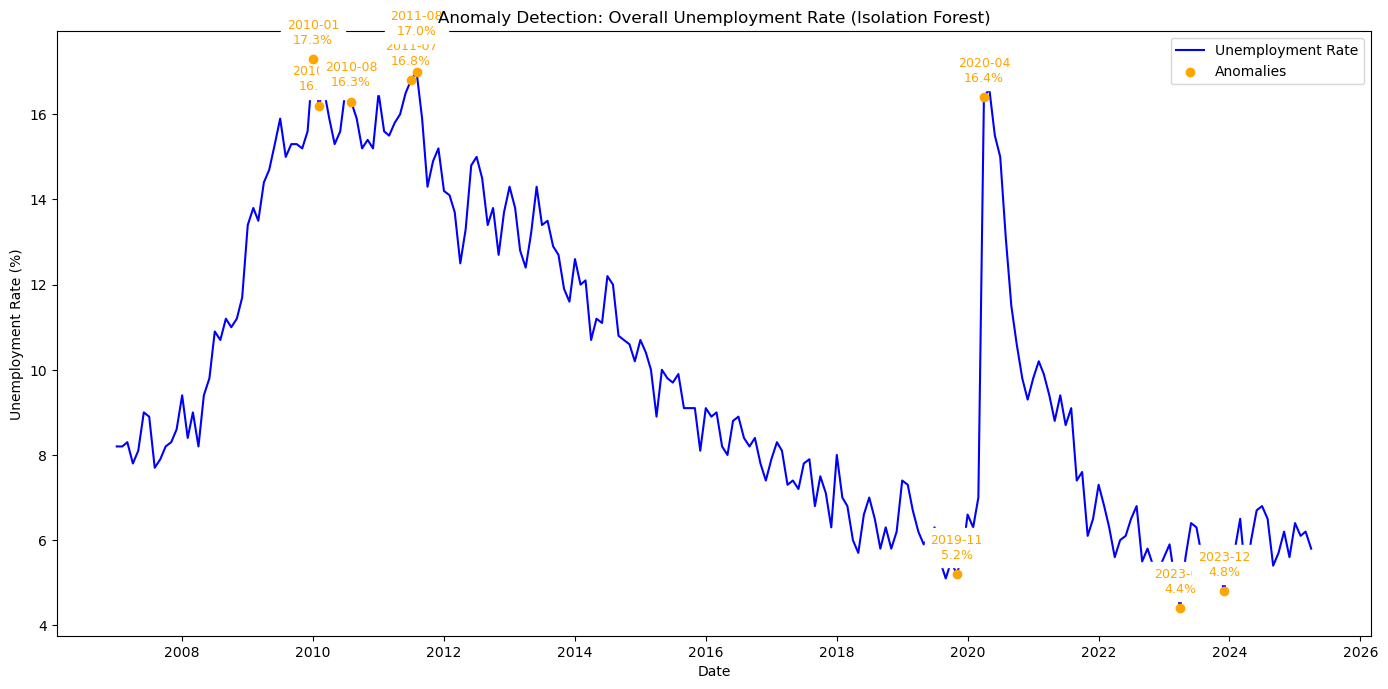

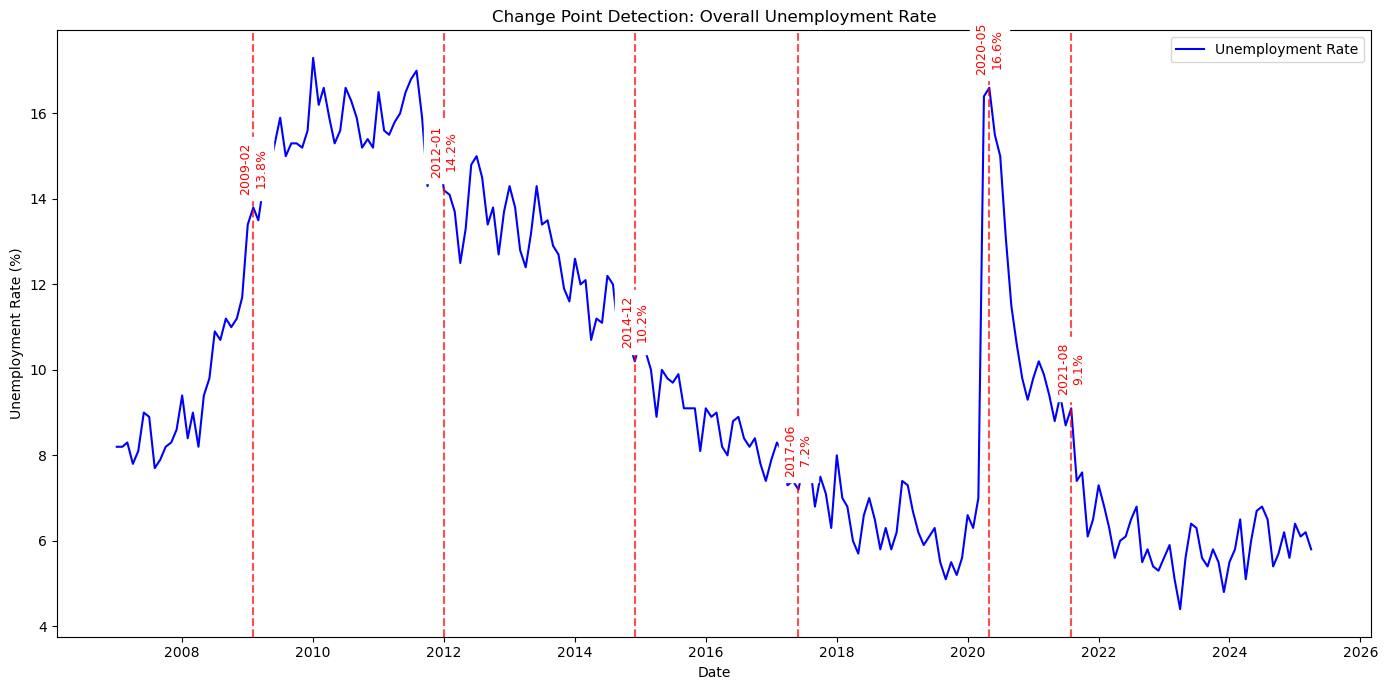


### Comparison of Anomaly Detection and Change Point Detection Charts

**Differences:**  
- The first chart (Anomaly Detection) highlights specific months where the unemployment rate is unusually high or low compared to the rest of the series. These points are marked as orange dots and represent statistical outliers—sudden, rare events that deviate from the typical pattern.
- The second chart (Change Point Detection) shows red dashed vertical lines at moments where the overall trend or statistical properties of the unemployment rate shift. These are not isolated outliers, but rather points where the series transitions to a new regime, such as after a recession or major policy change.

**Similarities:**  
Both charts are tools for analyzing the structure and behavior of the unemployment rate time series, but they focus on different types of events.  
- Each chart uses the same underlying data and time axis, making it easy to visually compare where anomalies and change points occur.
- Both methods help identify important moments in the data: anomalies reveal rare, extreme deviations, while change points indicate persistent shifts in trend or volatility.
- By overlaying these results on the unemployment rate, both charts provide context for interpreting economic events—whether they are sudden shocks (anomalies) or longer-term transitions (change points).
- Using both approaches together gives a more complete understanding of the data: you can see not only when the unemployment rate spiked or dropped unexpectedly, but also when the overall pattern of unemployment fundamentally changed. This dual perspective is valuable for researchers and policymakers seeking to understand both short-term disruptions and long-term structural changes in the labor market.


In [ ]:
# Plot anomaly detection with non-overlapping labels
plt.figure(figsize=(14, 10))
plt.plot(series.index, series.values, label='Unemployment Rate', color='blue')
plt.scatter(anomaly_dates, anomaly_values, color='orange', label='Anomalies', zorder=5)

# Place labels with vertical offset to avoid overlap
label_y_positions = []
min_vgap = 0.7  # Minimum vertical gap between labels

for date, value in zip(anomaly_dates, anomaly_values):
    # Find a y position that does not overlap with previous labels
    y_pos = value + 0.3
    for prev_x, prev_y in label_y_positions:
        if abs((date - prev_x).days) < 60 and abs(y_pos - prev_y) < min_vgap:
            y_pos = prev_y + min_vgap
    label_y_positions.append((date, y_pos))
    plt.text(
        date, y_pos,
        f"{date.strftime('%Y-%m')}\n{value:.1f}%",
        color='orange', fontsize=9, ha='center', va='bottom', backgroundcolor='white'
    )

plt.title('Anomaly Detection: Overall Unemployment Rate (Isolation Forest)')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.tight_layout()
plt.show()

# Plot change point detection for comparison
plt.figure(figsize=(14, 10))
plt.plot(series.index, series.values, label='Unemployment Rate', color='blue')
for cp in result[:-1]:  # exclude the last point (end of series)
    date = series.index[cp]
    value = series.iloc[cp]
    plt.axvline(date, color='red', linestyle='--', alpha=0.7)
    plt.text(
        date, value + 0.3,
        f"{date.strftime('%Y-%m')}\n{value:.1f}%",
        color='red', fontsize=9, rotation=90, va='bottom', ha='center', backgroundcolor='white'
    )
plt.title('Change Point Detection: Overall Unemployment Rate')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.tight_layout()
plt.show()

display(Markdown(
"""
### Comparison of Anomaly Detection and Change Point Detection Charts

**Differences:**  
- The first chart (Anomaly Detection) highlights specific months where the unemployment rate is unusually high or low compared to the rest of the series. These points are marked as orange dots and represent statistical outliers—sudden, rare events that deviate from the typical pattern.
- The second chart (Change Point Detection) shows red dashed vertical lines at moments where the overall trend or statistical properties of the unemployment rate shift. These are not isolated outliers, but rather points where the series transitions to a new regime, such as after a recession or major policy change.

**Similarities:**  
Both charts are tools for analyzing the structure and behavior of the unemployment rate time series, but they focus on different types of events.  
- Each chart uses the same underlying data and time axis, making it easy to visually compare where anomalies and change points occur.
- Both methods help identify important moments in the data: anomalies reveal rare, extreme deviations, while change points indicate persistent shifts in trend or volatility.
- By overlaying these results on the unemployment rate, both charts provide context for interpreting economic events—whether they are sudden shocks (anomalies) or longer-term transitions (change points).
- Using both approaches together gives a more complete understanding of the data: you can see not only when the unemployment rate spiked or dropped unexpectedly, but also when the overall pattern of unemployment fundamentally changed. This dual perspective is valuable for researchers and policymakers seeking to understand both short-term disruptions and long-term structural changes in the labor market.
"""
))

# Overlay Presidential Terms and Policy Events

Overlay U.S. presidential terms and annotate change points with policy headlines on the unemployment rate chartfor more context.

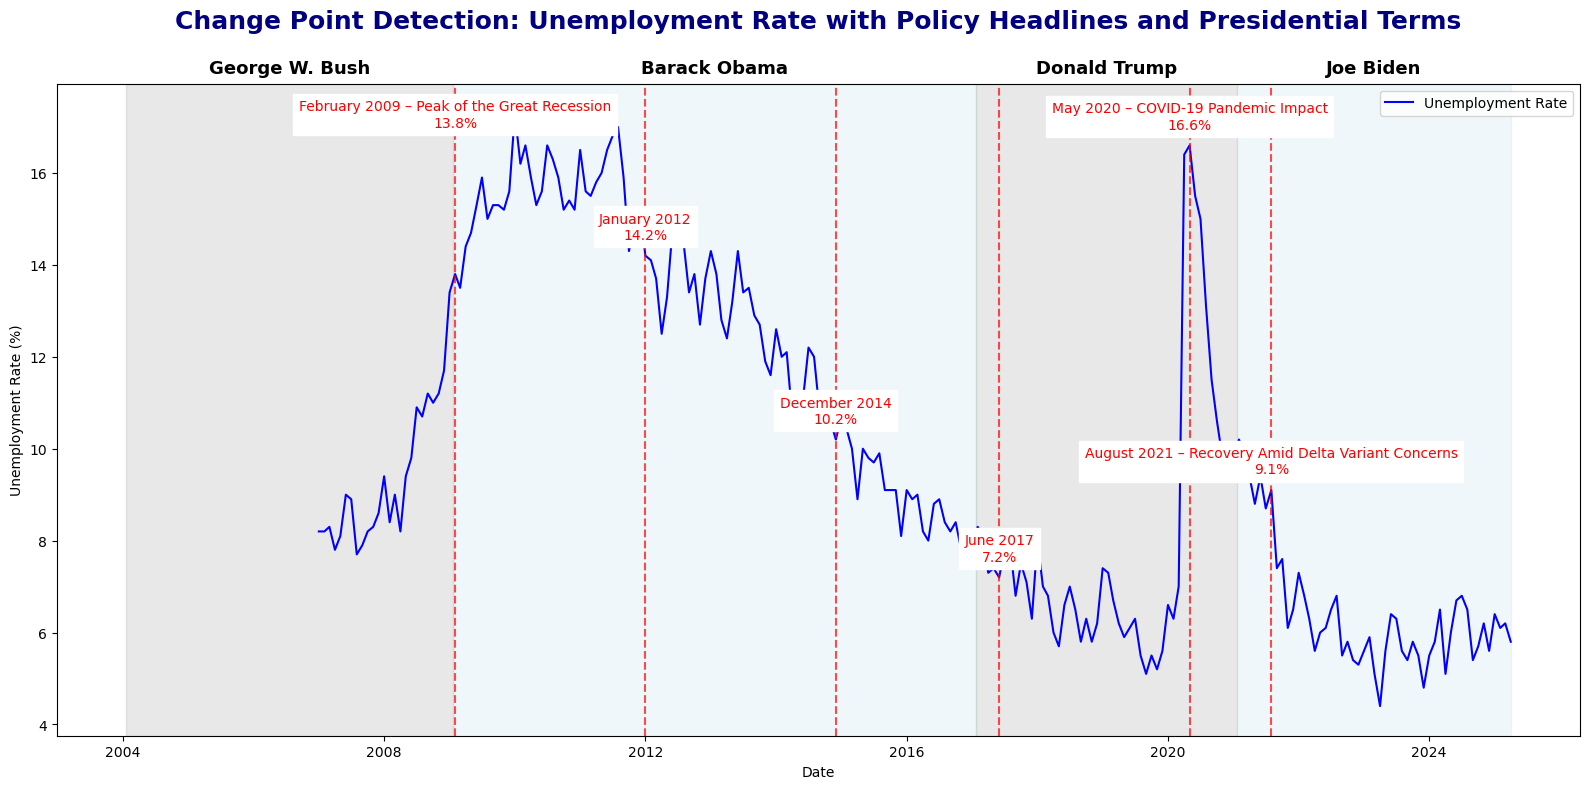


## Analysis Summary

The chart titled "Change Point Detection: Unemployment Rate with Policy Headlines and Presidential Terms" visually tracks the U.S. unemployment rate from 2004 to 2025 while highlighting key inflection points using change point detection methods. The blue line represents the monthly unemployment rate, and vertical red dashed lines indicate detected change points, each annotated with major economic or policy events that preceded or followed a noticeable shift in the unemployment trend. Overlaid backgrounds denote U.S. presidential terms: George W. Bush, Barack Obama, Donald Trump, and Joseph Biden. These temporal segments help contextualize how unemployment evolved under different administrations, offering a nuanced understanding of how fiscal and geopolitical events intersect with labor market performance.

Key turning points include February 2009, at the height of the Great Recession, where the unemployment rate surged following the 2008 financial crisis. Later markers, such as August 2011, align with the U.S. debt ceiling crisis and subsequent spending cuts, showing stagnation in job creation. A steady decline follows through the Obama administration, with another key point in February 2014 marking gradual recovery. The unemployment rate stabilizes during the Trump administration until May 2020, when the COVID-19 pandemic caused a sharp and unprecedented spike. August 2021 marks a slower recovery, as the Delta variant tempered economic reopening and job gains. The chart successfully connects unemployment shifts with policy and macroeconomic milestones.

This visual and statistical approach is extremely useful for analyzing historical economic data related to unemployment. It enables researchers, policymakers, and students to correlate sharp changes in labor market conditions with policy decisions, global events, or crises. By combining time series data with contextual annotations, the chart promotes a deeper understanding of economic causality and cyclical behavior. For future steps, integrating additional indicators—such as GDP growth, inflation, and labor force participation—could provide a more holistic analysis. Moreover, predictive modeling could be layered atop this framework to forecast how new policy decisions might influence future labor market outcomes.


In [ ]:
# Read the presidents CSV file
presidents_df = pd.read_csv("data/us_presidents_since_2004.csv")
presidents_df['date'] = pd.to_datetime(presidents_df['date'])

fig, ax = plt.subplots(figsize=(16, 10))
ax.plot(series.index, series.values, label='Unemployment Rate', color='blue')

# Overlay presidential terms as shaded regions
for i, row in presidents_df.iterrows():
    start = row['date']
    # Determine end of term: next president's start or end of series
    if i + 1 < len(presidents_df):
        end = presidents_df.loc[i + 1, 'date']
    else:
        end = series.index[-1]
    color = 'gray' if row['political party'] == 'Republican' else 'lightblue'
    ax.axvspan(start, end, color=color, alpha=0.18)

    # Annotate president name above the plot, evenly spaced
    mid = start + (end - start) / 2
    ax.annotate(
        row['president name'],
        xy=(mid, 1.01), xycoords=('data', 'axes fraction'),
        ha='center', va='bottom',
        fontsize=13, fontweight='bold',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=2)
    )

# Centered chart title
ax.set_title(
    'Change Point Detection: Unemployment Rate with Policy Headlines and Presidential Terms',
    fontsize=18, fontweight='bold', color='navy', pad=40, loc='center'
)

# Overlay change points with policy headlines (reuse label_positions from previous cell)
for (date, y_pos), cp in zip(label_positions, result[:-1]):
    date_key = date.to_period("M").to_timestamp()
    headline = headline_map.get(date_key, "")
    label = f"{date.strftime('%B %Y')}"
    if headline:
        label += f" – {headline}"
    label += f"\n{series.loc[date]:.1f}%"
    ax.axvline(date, color='red', linestyle='--', alpha=0.7)
    ax.text(
        date, y_pos,
        label,
        color='red', fontsize=10, rotation=0, va='bottom', ha='center', backgroundcolor='white'
    )

ax.set_xlabel('Date')
ax.set_ylabel('Unemployment Rate (%)')
ax.legend(['Unemployment Rate'])
plt.tight_layout()
plt.show()

display(Markdown("""
## Analysis Summary

The chart titled "Change Point Detection: Unemployment Rate with Policy Headlines and Presidential Terms" visually tracks the U.S. unemployment rate from 2004 to 2025 while highlighting key inflection points using change point detection methods. The blue line represents the monthly unemployment rate, and vertical red dashed lines indicate detected change points, each annotated with major economic or policy events that preceded or followed a noticeable shift in the unemployment trend. Overlaid backgrounds denote U.S. presidential terms: George W. Bush, Barack Obama, Donald Trump, and Joseph Biden. These temporal segments help contextualize how unemployment evolved under different administrations, offering a nuanced understanding of how fiscal and geopolitical events intersect with labor market performance.

Key turning points include February 2009, at the height of the Great Recession, where the unemployment rate surged following the 2008 financial crisis. Later markers, such as August 2011, align with the U.S. debt ceiling crisis and subsequent spending cuts, showing stagnation in job creation. A steady decline follows through the Obama administration, with another key point in February 2014 marking gradual recovery. The unemployment rate stabilizes during the Trump administration until May 2020, when the COVID-19 pandemic caused a sharp and unprecedented spike. August 2021 marks a slower recovery, as the Delta variant tempered economic reopening and job gains. The chart successfully connects unemployment shifts with policy and macroeconomic milestones.

This visual and statistical approach is extremely useful for analyzing historical economic data related to unemployment. It enables researchers, policymakers, and students to correlate sharp changes in labor market conditions with policy decisions, global events, or crises. By combining time series data with contextual annotations, the chart promotes a deeper understanding of economic causality and cyclical behavior. For future steps, integrating additional indicators—such as GDP growth, inflation, and labor force participation—could provide a more holistic analysis. Moreover, predictive modeling could be layered atop this framework to forecast how new policy decisions might influence future labor market outcomes.
"""))
